In [1]:
#!/usr/bin/python

import time
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta

In [2]:
from pip import main
file_name="Plum_Brook_Feb7_1400hr_to_End.json"
name_to_read=os.path.join(file_name)

data_path=os.path.dirname("Plum_Brook_Feb7_1400hr_to_End.json")

In [3]:
pp = pprint.PrettyPrinter(indent=4)

with open(name_to_read, 'r') as f:
    df = pd.json_normalize(json.load(f))
df.to_csv('json_file.csv')

In [4]:
print("Read in {} rows and with {} variables".format(df.shape[0], df.shape[1]))
print("  => First Timestamp: {}".format(df.iloc[0].server_timestamp))
print("  => Last Timestamp : {}".format(df.iloc[-1].server_timestamp))
names_payload=df.columns.values
print(type(df[names_payload[0]].values))
#np.savetxt('variable_names.txt',names_payload,fmt='%s')
# filter out zeros or whatever you like.  Do this before extracting times to keep
# the x/y arrays the same size.
df = df[(df['payload.fAbsolutePressure'] != 0)]

Read in 6050 rows and with 241 variables
  => First Timestamp: 2022-02-07 14:01:30.922000+00:00
  => Last Timestamp : 2022-02-09 17:17:50.063000+00:00
<class 'numpy.ndarray'>


In [5]:
# the time that the data were sent to the server is in server_timestamp
times = pd.to_datetime(df['server_timestamp'])
print(type(df['server_timestamp'].values[0]))
print(type(times[0]))
pressure  = df['payload.fAbsolutePressure']
sfc_temp  = df['payload.fSFCStatus.fCPU_Temp']
dini_temp = df['payload.fDiniTempFPGA']
richwest_power = df['payload.fPowerStat.fRICH_West.fPower']
dctboxtemp=df['payload.dctBoxTemp']
Magnet_probes=df['payload.fMagnetHSK.tempProbeAll']
#print(type(Magnet_probes.values))
#print(type(Magnet_probes.values[0]))
#print(Magnet_probes.values[0])

len(times)
payton = []
for i in range(0, 1044):
    payton.append(times[i])
for i in range(1045, 1203):
    payton.append(times[i])
for i in range(1204, 2378):
    payton.append(times[i])
for i in range(2379, 6050):
    payton.append(times[i])
#payton.append(times[1044])
len(payton)
pab = 40
'pa'+str(pab)


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


'pa40'

In [6]:
start_power=df.loc[df['payload.fPowerStat.fRICH_West.fPower']>100].index[0]
#start_power=times[df.iloc[df['payload.fPowerStat.fRICH_West.fPower']>100][0]]

mainhsk_temps  = df['payload.main_temps'].values
DCT_temps  = df['payload.dctThermistor'].values
heliumLVL=df['payload.fMagnetHSK.heliumLevels']

In [7]:
# to get just the first list element for each timestamp of the series...
#mainhsk_temps_array=np.empty([len(mainhsk_temps),len(mainhsk_temps[0])])
#temp_array=np.empty([len(mainhsk_temps[0]),])
temp_list=[]
for i in mainhsk_temps: temp_list.append(i)
mainhsk_temps_array=np.asarray(temp_list)
# now for DCT temps 
temp_list=[]
for i in DCT_temps: temp_list.append(i)
DCT_temps_array=np.asarray(temp_list)
#and helium levels
temp_list=[]
for i in heliumLVL: temp_list.append(i)
helium_levels_array=np.asarray(temp_list)
time_elapsed=pd.to_timedelta(times.values-times.values[0],unit='hours',errors="raise")
time_deltas=time_elapsed/timedelta(hours=1) # can also do minutes
mainhsk_names=pd.read_csv('mainhsk_temp_sensors.txt')
# legend/order of loading csvs i guess
NASA_names=pd.read_csv("keith_final_legend_order.csv")
#print(NASA_names.ID.values[2])
# NASA TCs loaded as a list first
NASA_TCs=[]
for name in NASA_names.ID:
    NASA_TCs.append(pd.read_csv(name+"_csv.csv",skiprows=1))
# convert NASA times to timestamp proper
#adjust to UTC like the other times
time_change = timedelta(hours=5)
for dfN in NASA_TCs:
    dfN['Times']=pd.to_datetime(dfN['Timestamp'])
    dfN['Times'] = dfN['Times'] + time_change

# South Here original data

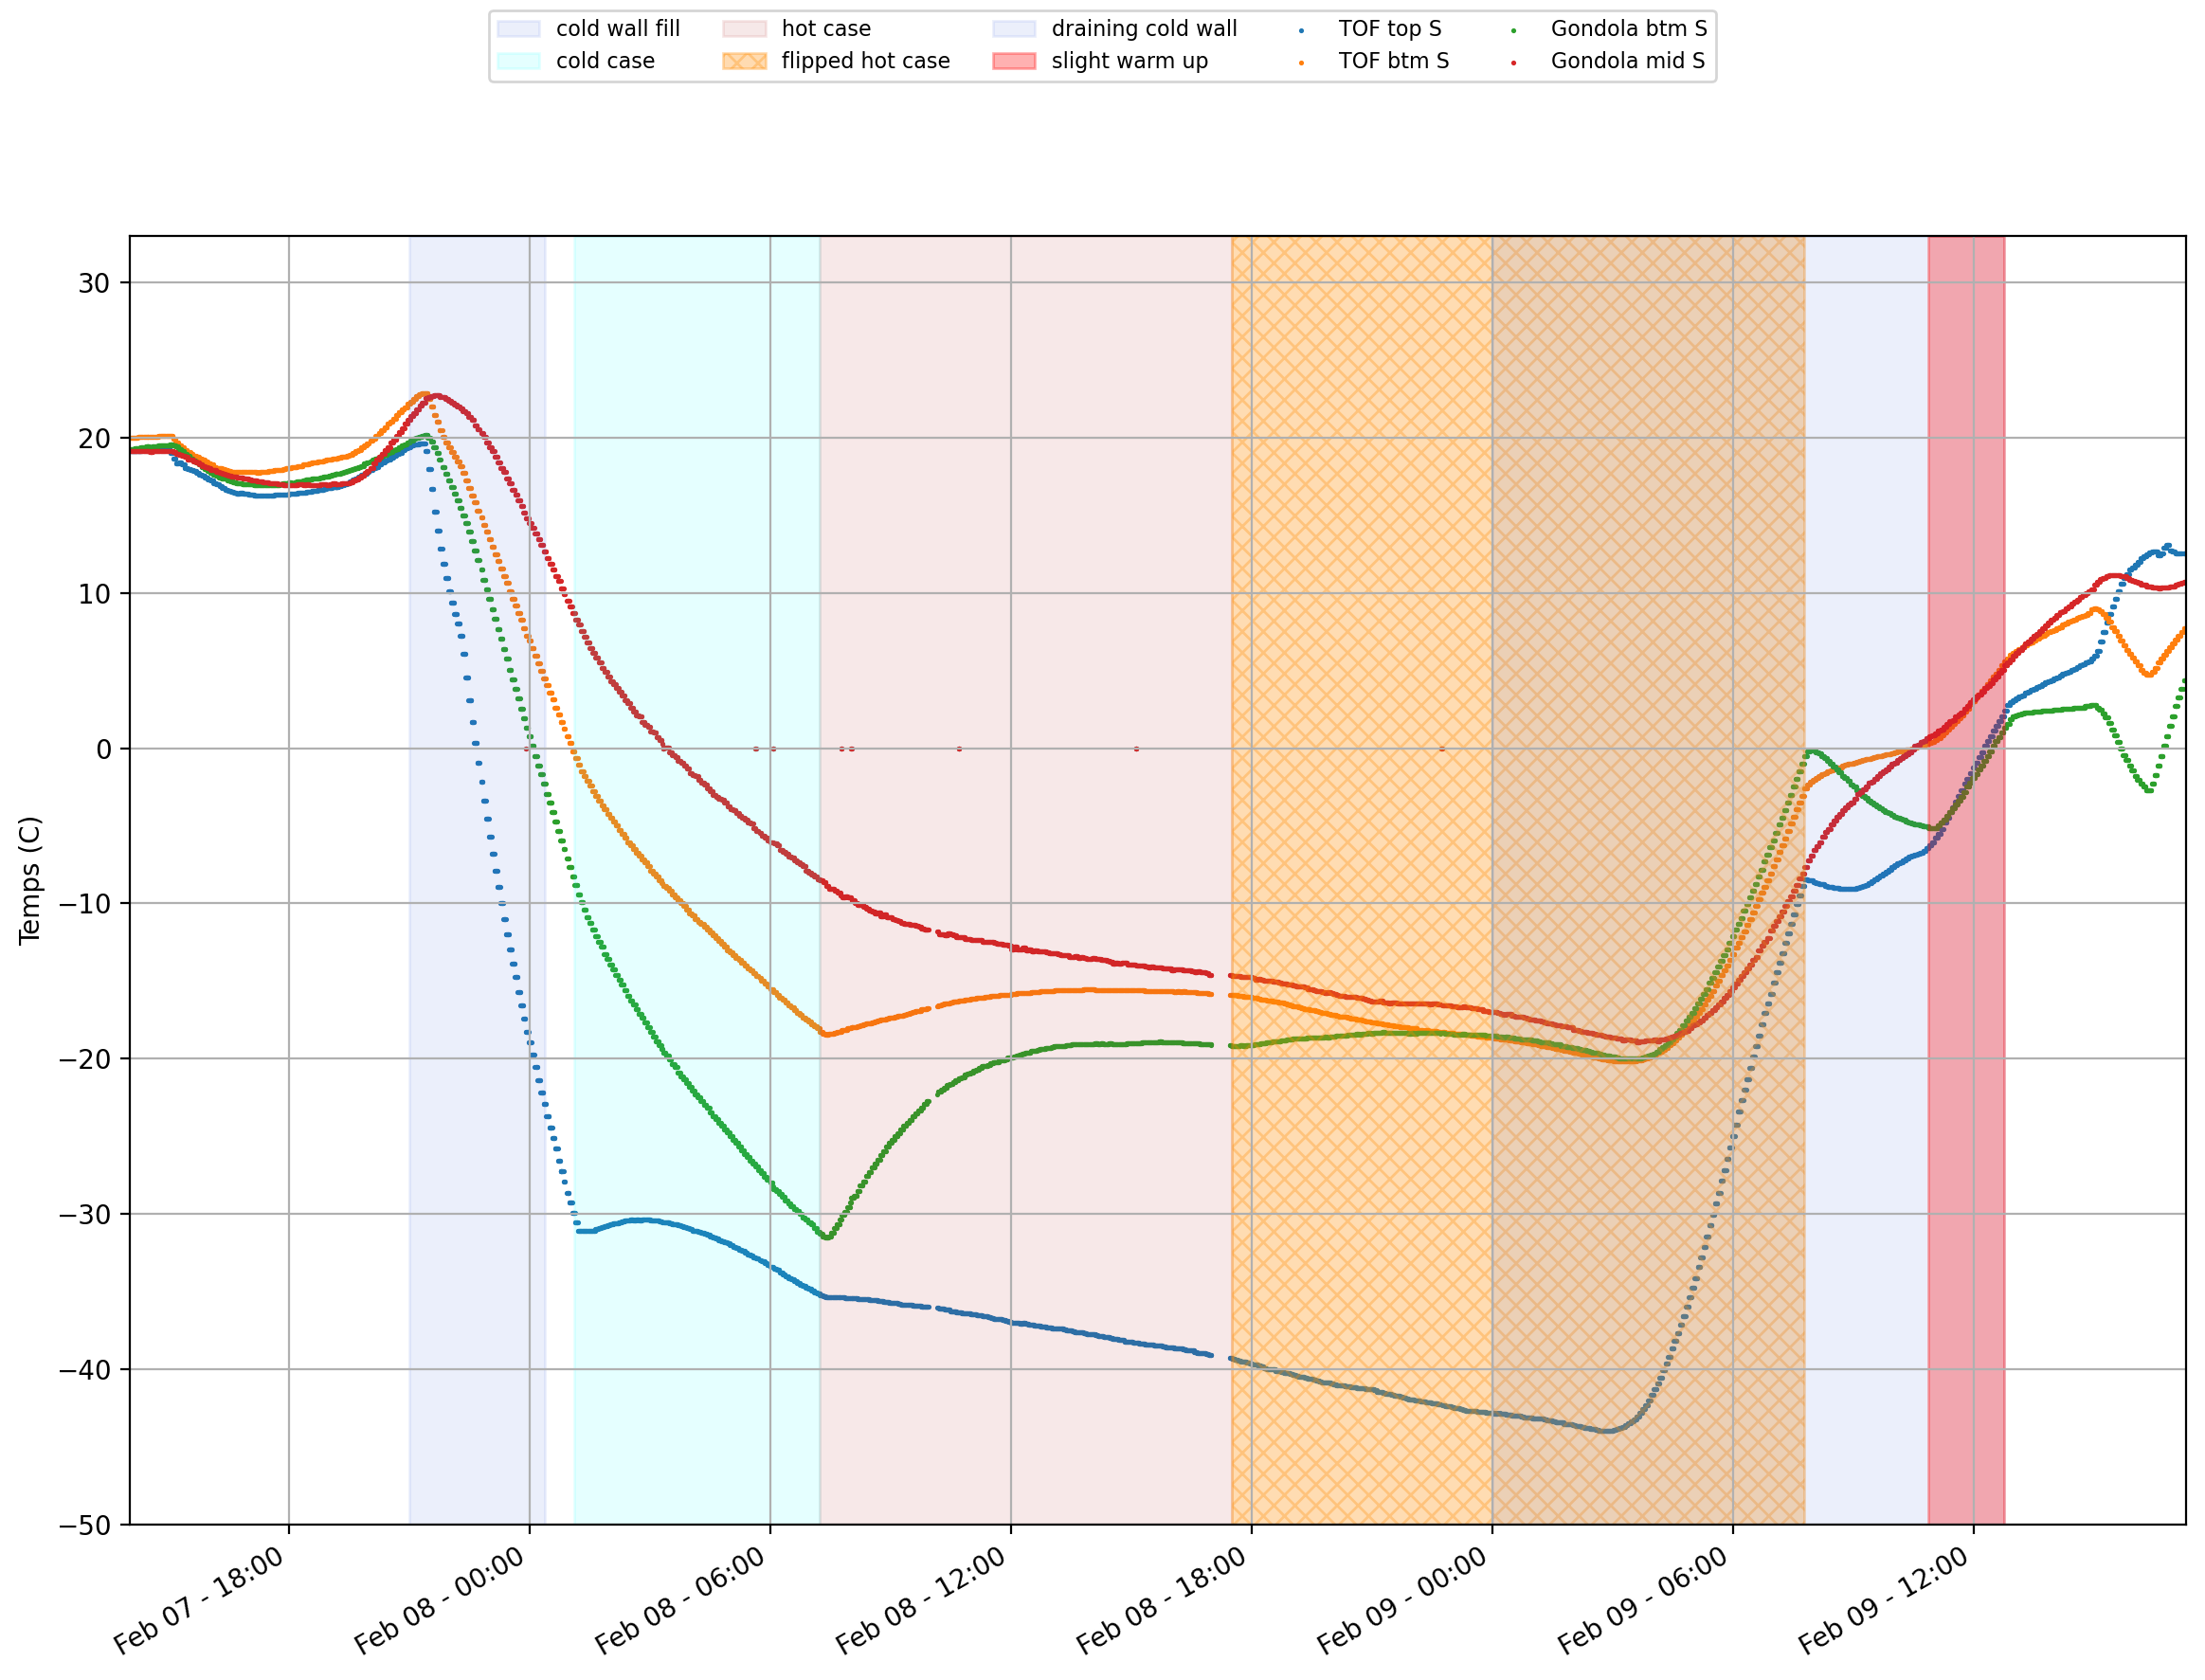

'len(mainhsk_temps_array)\nfor i in range(0,6046):\n    print(mainhsk_temps_array[i,7])'

In [13]:
print(len(mainhsk_temps_array[0]), np.size(mainhsk_temps_array[0,:]))

30 30


In [10]:
#j determines which slice of data
#dT is an amount of temperature we expect the next data point to be within. If the graph changes too rapidly it likely is due to
#some kind of bad data

def Masking(j, dT):
    mainhsk_temps_array_masked = np.copy(mainhsk_temps_array[:,j])
    #First attempt at a real mask. Assuming values should be some what continuous, put a condition that if the next value
    #differs by too much, then that element is candidate for bad value
    for i in range(1,6047):
        if abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) > dT and np.isnan(mainhsk_temps_array_masked[i-1]) == False:
            mainhsk_temps_array_masked[i] = np.nan
            k = np.copy(i)
            if np.isnan(mainhsk_temps_array_masked[k]):
                while abs(mainhsk_temps_array[k+1,j] - mainhsk_temps_array[k,j]) == 0:
                    if abs(mainhsk_temps_array[i-1,j] - mainhsk_temps_array[k,j]) > dT:
                        mainhsk_temps_array_masked[k] = np.nan
                        k = k + 1
        if np.isnan(mainhsk_temps_array_masked[i-1]) == True and abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) == 0:
            mainhsk_temps_array_masked[i] = np.nan
    #for i in range(2,6047):
     #   if abs(mainhsk_temps_array[i,j] - 2*mainhsk_temps_array[i-1,j] + mainhsk_temps_array[i-2,j]) > dl:
      #      mainhsk_temps_array_masked[i] = np.nan
    
    return mainhsk_temps_array_masked

In [11]:
def Masking2(j, dT):
    mainhsk_temps_array_masked = np.copy(mainhsk_temps_array[:,j])
    #First attempt at a real mask. Assuming values should be some what continuous, put a condition that if the next value
    #differs by too much, then that element is candidate for bad value
    for i in range(1,6047):
        if abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) > dT and np.isnan(mainhsk_temps_array_masked[i-1]) == False:
            mainhsk_temps_array_masked[i] = np.nan
            k = np.copy(i)
            if np.isnan(mainhsk_temps_array_masked[k]):
                while abs(mainhsk_temps_array[k+1,j] - mainhsk_temps_array[k,j]) == 0:
                    if abs(mainhsk_temps_array[i-1,j] - mainhsk_temps_array[k,j]) > dT:
                        mainhsk_temps_array_masked[k] = np.nan
                        k = k + 1
    
    return mainhsk_temps_array_masked

In [12]:
#Test = np.copy(Masking(7,3,1))
#for i in range(0, 6047):
 #   if np.isnan(Test[i]) == True:
  #      print(i, Test[i])

# Creating the Mask

In [13]:
#This cell does the masking
mainhsk_SH_list = [7, 5, 3, 8]
mainhsk_SH_masked_list = []
for j in mainhsk_SH_list:
    mainhsk_temps_array_masked = np.copy(mainhsk_temps_array[:,j])
    #First attempt at a real mask. Assuming values should be some what continuous, put a condition that if the next value
    #differs by too much, then that element is candidate for bad value
    for i in range(1,6047):
        if abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) > 3 and np.isnan(mainhsk_temps_array_masked[i-1]) == False:
            mainhsk_temps_array_masked[i] = np.nan
        if np.isnan(mainhsk_temps_array_masked[i-1]) == True and abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) == 0:
            mainhsk_temps_array_masked[i] = np.nan
    mainhsk_SH_masked_list.append(mainhsk_temps_array_masked)
#times_masked = times
#times_masked[1]


#Simple mask that masks all values less than 0
'''for  i in range(1,6046):
    if mainhsk_temps_array[i,7] < 0:
        mainhsk_temps_array_masked[i] = np.nan'''


#Masks all values equal to 0
'''for  i in range(0,6047):
    if mainhsk_temps_array[i,7] == 0:
        mainhsk_temps_array_masked[i] = np.nan
        #times_masked.values[i] = np.nan'''


#First attempt at a real mask. Assuming values should be some what continuous, put a condition that if the next value
#differs by too much, then that element is candidate for bad value
'''for i in range(1,6047):
        if abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) > 3 and np.isnan(mainhsk_temps_array_masked[i-1]) == False:
            mainhsk_temps_array_masked[i] = np.nan
        if np.isnan(mainhsk_temps_array_masked[i-1]) == True and abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) == 0:
            mainhsk_temps_array_masked[i] = np.nan
    mainhsk_SH_masked_list.append(mainhsk_temps_array_masked)'''

#print(len(mainhsk_temps_array_masked), times.values[1044])

'''for i in range(0,6047):
    if np.isnan(mainhsk_temps_array_masked[i]) == True:
        print(i, mainhsk_temps_array_masked[i], mainhsk_temps_array[i,j])'''

'for i in range(0,6047):\n    if np.isnan(mainhsk_temps_array_masked[i]) == True:\n        print(i, mainhsk_temps_array_masked[i], mainhsk_temps_array[i,j])'

In [14]:
#print(times[1])

# South Here Masked

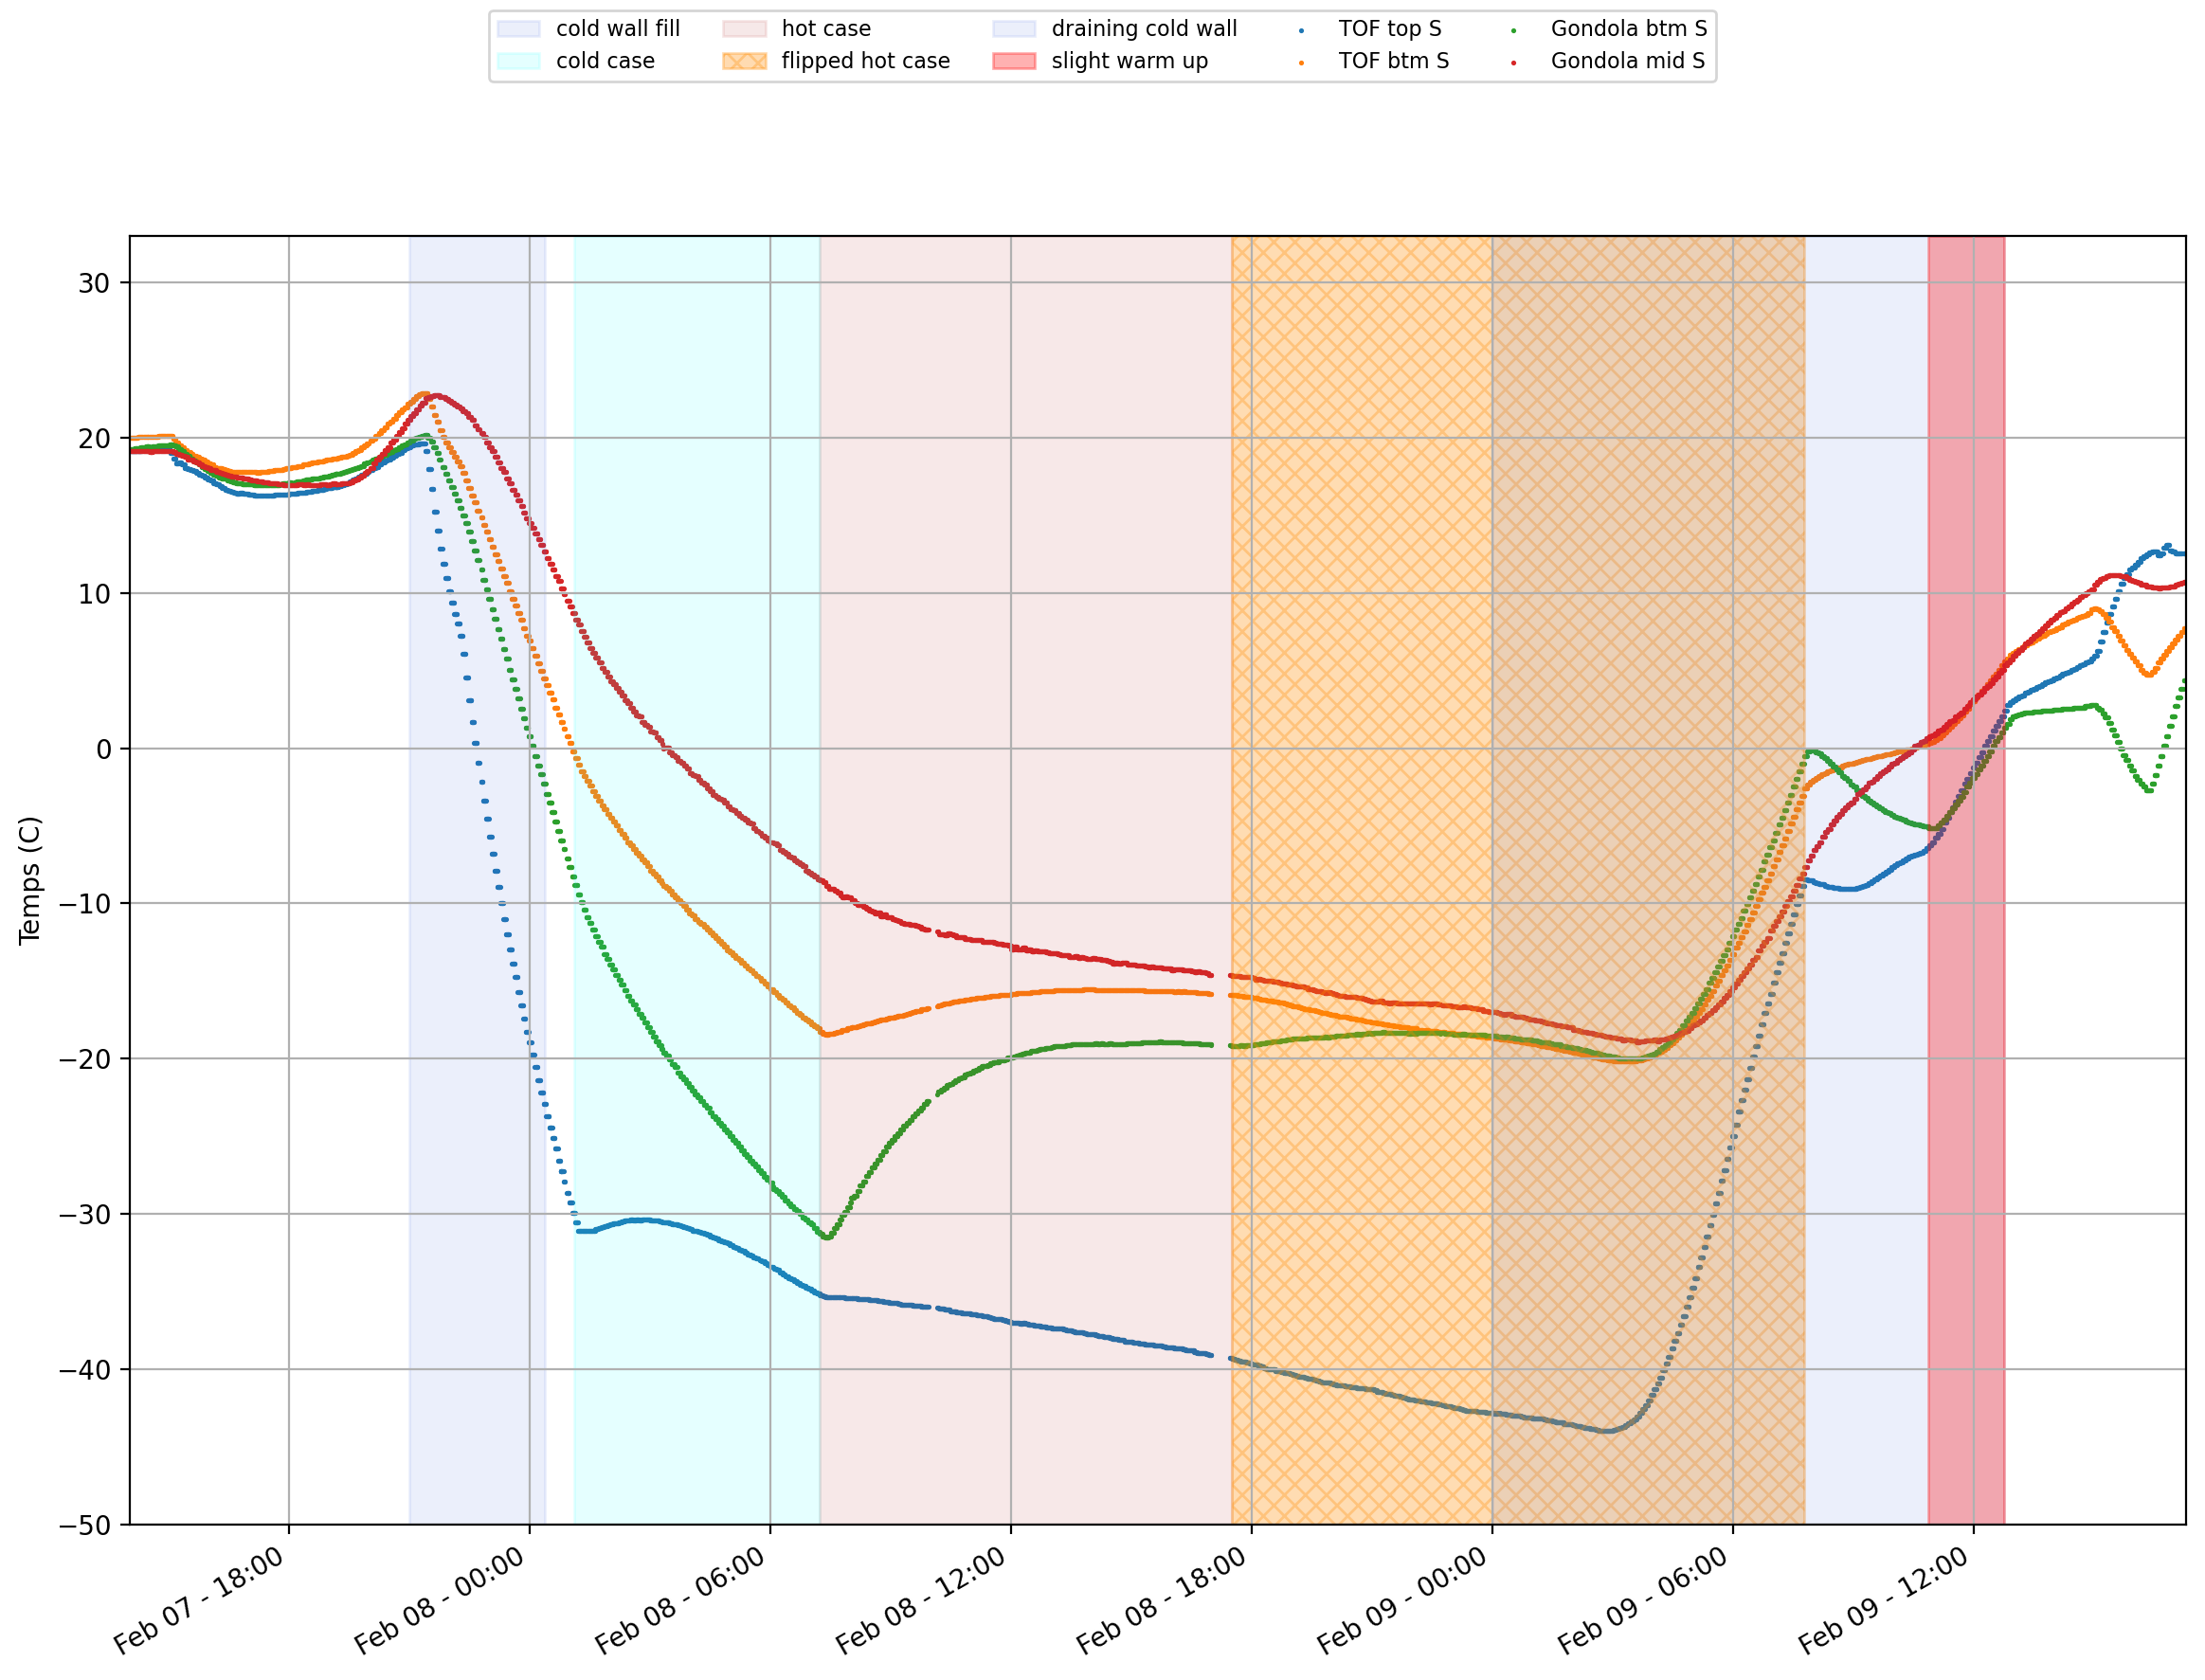

# Checking Data type list stuff

In [16]:
Indexes = pd.read_csv('Payton_notes_vars.csv') #Reads in the names of the lists from the excell sheet
#print(Indexes[0,0])
Indexlist = Indexes['NAME'].tolist()
Index = []
Index_Temp_list = []
Index_array = []

#Makes a list of all the different lists we want to look at
for i in range(0,len(Indexlist)):
    Index.append(df[Indexlist[i]])
    
#Turns all those lists into arrays
for i in range(0,len(Index)):
    Temp_list_1 = []
    for j in Index[i]:
        Temp_list_1.append(j)
    Index_array.append(np.asarray(Temp_list_1))
#Index_array2 = np.asarray(Index_array)

Index35=df['payload.fChargeControlStat.fPVA'].values
#Index40=df['payload.fRICHBoardStates'].values
#Index126=df['payload.fSFCStatus.fCPULoad'].values
#Index151=df['payload.fTOFStatus.fFEETemp.1'].values
temp_list35 = []
#temp_list40 = []
#temp_list126 = []
#temp_list151 = []
for i in Index35:
    temp_list35.append(i)
Index35_array=np.asarray(temp_list35)

'''for i in Index40:
    temp_list40.append(i)
Index40_array=np.asarray(temp_list40)

for i in Index126:
    temp_list126.append(i)
Index126_array=np.asarray(temp_list126)

for i in Index151:
    temp_list151.append(i)
Index151_array=np.asarray(temp_list151)'''
#print(type(Index35[0][0]))
print(Indexlist[0],type(Index_array[0][0][0]))
print(Indexlist[1],type(Index_array[1][0]))
print(Indexlist[2],type(Index_array[2][0][0]))
print(Indexlist[3],type(Index_array[3][0][0]))
print(Indexlist[4],type(Index_array[4][0][0]))
print(Indexlist[5],type(Index_array[5][0][0]))
print(Indexlist[6],type(Index_array[6][0][0]))
print(Indexlist[7],type(Index_array[7][0][0]))
print(Indexlist[8],type(Index_array[8][0][0]))
print(Indexlist[9],type(Index_array[9][0][0]))
print(Indexlist[10],type(Index_array[10][0][0]))
print(Indexlist[11],type(Index_array[11][0][0]))
print(Indexlist[12],type(Index_array[12][0][0]))
print(Indexlist[13],type(Index_array[13][0][0]))
print(Indexlist[14],type(Index_array[14][0][0]))
print(Indexlist[15],type(Index_array[15][0][0]))
print(Indexlist[16],type(Index_array[16][0][0]))
print(Indexlist[17],type(Index_array[17][0][0]))
print(Indexlist[18],type(Index_array[18][0][0]))
print(Indexlist[19],type(Index_array[19][0][0]))
print(Indexlist[20],type(Index_array[20][0][0]))
print(Indexlist[21],type(Index_array[21][0][0]))
print(Indexlist[22],type(Index_array[22][0][0]))
print(Indexlist[23],type(Index_array[23][0][0]))
print(Indexlist[24],type(Index_array[24][0][0]))
print(Indexlist[25],type(Index_array[25][0][0]))
print(Indexlist[26],type(Index_array[26][0][0]))
print(Indexlist[27],type(Index_array[27][0][0]))
print(Indexlist[28],type(Index_array[28][0][0]))
print(Indexlist[29],type(Index_array[29][0]))
print(Indexlist[30],type(Index_array[30][0][0]))
#print(Index35_array)

C:\Users\17243\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


payload.fChargeControlStat.fPVA <class 'dict'>
payload.fRICHBoardStates <class 'list'>
payload.fSFCStatus.fCPULoad <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.1 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.8 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.4 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.3 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.5 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.0 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.2 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.7 <class 'numpy.float64'>
payload.fTOFStatus.fFEETemp.6 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.3 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.6 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.4 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.7 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.2 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.8 <class 'numpy.float64'>
payload.fTOFStatus.fFEEImon.1 <class 'numpy.float64

In [17]:
print(type(Index35_array))
print(type(Index35_array[0]))
print(type(Index35_array[0,0]))
print(len(Index35_array[0]))
print(type(Index_array[0][0][0]))
print(Index35_array[0,0].keys())
print(Index_array[0][0][0].keys())
print(Index35_array[0,3].get('fTemp'))
print(type(Index35_array[0,3].get('fTemp')))
print(Index35_array[3,0].get('fTemp'))
print(Index_array[0][3][0].get('fTemp'))
print(Index_array[0][0][3].get('fTemp'))
#print(Index35_array[:,0]['fTemp'][0])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
4
<class 'dict'>
dict_keys(['fCurrent', 'fVoltage', 'fTotCurrent', 'fTemp'])
dict_keys(['fCurrent', 'fVoltage', 'fTotCurrent', 'fTemp'])
[23.900001525878906, -273.1499938964844, -273.1499938964844, 13.18701171875]
<class 'list'>
[22.40000343322754, -273.1499938964844, -273.1499938964844, -273.1499938964844]
[22.40000343322754, -273.1499938964844, -273.1499938964844, -273.1499938964844]
[23.900001525878906, -273.1499938964844, -273.1499938964844, 13.18701171875]


In [18]:
print(len(times), len(Index_array[3]))
print(type(times), type(Index_array[3][0]))
print(times.size, Index_array[3].size)
print(times.size, Index_array[0][3].size)
print(times.size, len(Index_array[0][3]))
print(Index_array[3].shape, Index_array[3][0].shape)
print(Index_array[3][0,1])
#for i in range(2,len(Indexlist)):    
 #   print(Indexlist[i], Index_array[i])

6047 6047
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
6047 48376
6047 4
6047 4
(6047, 8) (8,)
0.0


In [ ]:
print(len(Index_array[2]), type(Index_array[2]))
print(Index_array[2][0][1])
print(type(Index_array[29][0]))
print(Index_array[29][0])
print(len(Index_array[29]))
print(type(Index_array[2][0,0]))
print(len(Index_array[3][0]))
print(times.values[2378])

In [ ]:
#This cell is dealing with indicies 1 and 29
#The keys you want to use are 'fCitirocSTemp', 'fCitirocNTemp', and 'fBoardTemp'

Indi = []
NEi = []
for i in range(0,6047):
    if len(Index_array[1][i]) > 0:
        #print(i)
        Indi.append(i)
        NEi.append(Index_array[1][i])
#print(len(Index_array[1][0]))
NewDictTemp = []
for i in range(0,len(times)):
    NewDictTemp.append(np.nan)
for i in Indi:
    NewDictTemp[i] = Index_array[1][i][51]['fCitirocNTemp'] #'fCitirocSTemp', 'fCitirocNTemp', and 'fBoardTemp'
#for i in range(0, 6047):                                 #The third index can run from 0 to 51
    #print(i, NewfCitirocSTemp[i], times.values[i])
print(type(NewDictTemp))
NewDictTemp_array=np.asarray(NewDictTemp)
print(type(NewDictTemp_array), len(NewDictTemp_array))
#print(NewfCitirocSTemp_array)
print(len(Indi), Indi[0], Indi[-1])
print(NewDictTemp_array[0], NewDictTemp_array[Indi[0]])
print(type(NewDictTemp_array[0]), type(NewDictTemp_array[Indi[0]]))
print(NewDictTemp_array.max())

In [ ]:
#Still dealing with indicies 1 and 29
print(type(NEi[1][1]), len(NEi[1]))
print(NEi[1][1].keys())
print(NEi[1][1].get('fCitirocSTemp'), type(NEi[1][1].get('fBoardTemp')), NEi[1][1].get('fCitirocNTemp'))
for j in range(0,5027):
    for i in range(0,52):
    #print(type(Index_array[1][914]), len(Index_array[1][914]))
    #print(type(NEi[i][0]), len(NEi[i][0]))
    #if NEi[j][i]['fBoardSTemp'] != None or NEi[j][i]['fCitirocNTemp'] != None
    #print(NEi[1][i].get('fCitirocSTemp'), NEi[1][i].get('fBoardTemp'), NEi[1][i].get('fCitirocNTemp'))
        #print(len(NEi[j][i]),NEi[1][i].get('fCitirocSTemp'), NEi[1][i].get('fCitirocNTemp'), NEi[1][i].get('fPayloadSide'), NEi[1][i].get('fBoardTemp'), NEi[1][i].get('fSlotIndex'))
        if len(NEi[j][i]) != 5:
            print(len(NEi[j][i]))

In [ ]:
# Now make a plot
fig = plt.figure(figsize=(14, 10), dpi=200)
axs=fig.add_subplot(111)
gs = fig.add_gridspec(1, 1)
#axs = gs.subplots(sharex=True, sharey=False)
#axs = gs.subplots()
#axs.scatter(times, pressure, marker='.')
#axs.set_ylabel("Pressure (Torr)")
#|axs.set_ylim([1, 759])


# need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2017, 11, 28, 23, 55, 59, 342380)
cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
power_on_DAQ = times[start_power]
cold_case_start=datetime(2022, 2, 8,1,6,0,0)
cold_case_end=datetime(2022, 2, 8,7,14,0,0)
hot_case_start=cold_case_end
hot_case_end=datetime(2022, 2, 8,17,30,0,0)
kickflip_start=hot_case_end
discharge_magnet = datetime(2022,2,8,20,35,0,0)
discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
#kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
kickflip_end=datetime(2022,2,9,7,46,0,0)
slight_warmup_start=datetime(2022,2,9,10,52,0,0)
drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
slight_warmup_end=datetime(2022,2,9,12,45,0,0)
evacuation_start = datetime(2022,2,7,17,45,0,0)
evacuation_end = datetime(2022,2,9,17,00,0,0)
DAQ_Run = datetime(2022,2,8,5,41,0,0)
DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
heater_start=datetime(2022,2,8,13,18,0,0)
heater_max=datetime(2022,2,8,18,52,0,0)

# hatches for timespans
axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")


#size for markers visibility
s0=3


# south here : seq=1
#for i in range(0,len(Index_array[Ind][0])):
axs.scatter(times, NewDictTemp_array, marker='.',s=s0,label=mainhsk_names.Location.values[7]) # TOF top South
#axs.set_ylim([0, 100])
axs.set_xlim([times.values[0],times.values[-1]])


axs.set_ylabel("Temps (C)")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
plt.gcf().autofmt_xdate()
#axs[0].grid()
axs.grid()
#plt.legend(loc='upper center', fontsize=8)
handles, labels = axs.get_legend_handles_labels()
#lgd = axs[1].legend(handles, labels)
#for legend_handle in lgd.legendHandles:
#    legend_handle.set_sizes([20])
#labels[6]._legmarker.set_markersize(6)
lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
# as many of these as axs[1].scatter above

In [ ]:
print(Index_array[1][935][0].keys())

In [ ]:
#Choose your character (Index)
#This works for all indexes 3 to 26
Ind = 2

# Now make a plot
fig = plt.figure(figsize=(14, 10), dpi=200)
axs=fig.add_subplot(111)
gs = fig.add_gridspec(1, 1)
#axs = gs.subplots(sharex=True, sharey=False)
#axs = gs.subplots()
#axs.scatter(times, pressure, marker='.')
#axs.set_ylabel("Pressure (Torr)")
axs.set_ylim([1, 759])


# need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2017, 11, 28, 23, 55, 59, 342380)
cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
power_on_DAQ = times[start_power]
cold_case_start=datetime(2022, 2, 8,1,6,0,0)
cold_case_end=datetime(2022, 2, 8,7,14,0,0)
hot_case_start=cold_case_end
hot_case_end=datetime(2022, 2, 8,17,30,0,0)
kickflip_start=hot_case_end
discharge_magnet = datetime(2022,2,8,20,35,0,0)
discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
#kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
kickflip_end=datetime(2022,2,9,7,46,0,0)
slight_warmup_start=datetime(2022,2,9,10,52,0,0)
drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
slight_warmup_end=datetime(2022,2,9,12,45,0,0)
evacuation_start = datetime(2022,2,7,17,45,0,0)
evacuation_end = datetime(2022,2,9,17,00,0,0)
DAQ_Run = datetime(2022,2,8,5,41,0,0)
DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
heater_start=datetime(2022,2,8,13,18,0,0)
heater_max=datetime(2022,2,8,18,52,0,0)


# hatches for timespans
axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")


#size for markers visibility
s0=3


# south here : seq=1
for i in range(0,len(Index_array[Ind][0])):
    axs.scatter(times, Index_array[Ind][:,i], marker='.',s=s0,label=mainhsk_names.Location.values[7]) # TOF top South
axs.set_ylim([-50, 33])
axs.set_xlim([times.values[0],times.values[-1]])


axs.set_ylabel("Temps (C)")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
plt.gcf().autofmt_xdate()
#axs[0].grid()
axs.grid()
#plt.legend(loc='upper center', fontsize=8)
handles, labels = axs.get_legend_handles_labels()
#lgd = axs[1].legend(handles, labels)
#for legend_handle in lgd.legendHandles:
#    legend_handle.set_sizes([20])
#labels[6]._legmarker.set_markersize(6)
lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
# as many of these as axs[1].scatter above

# Ends the Data type list nonsense

# RICH Original Data

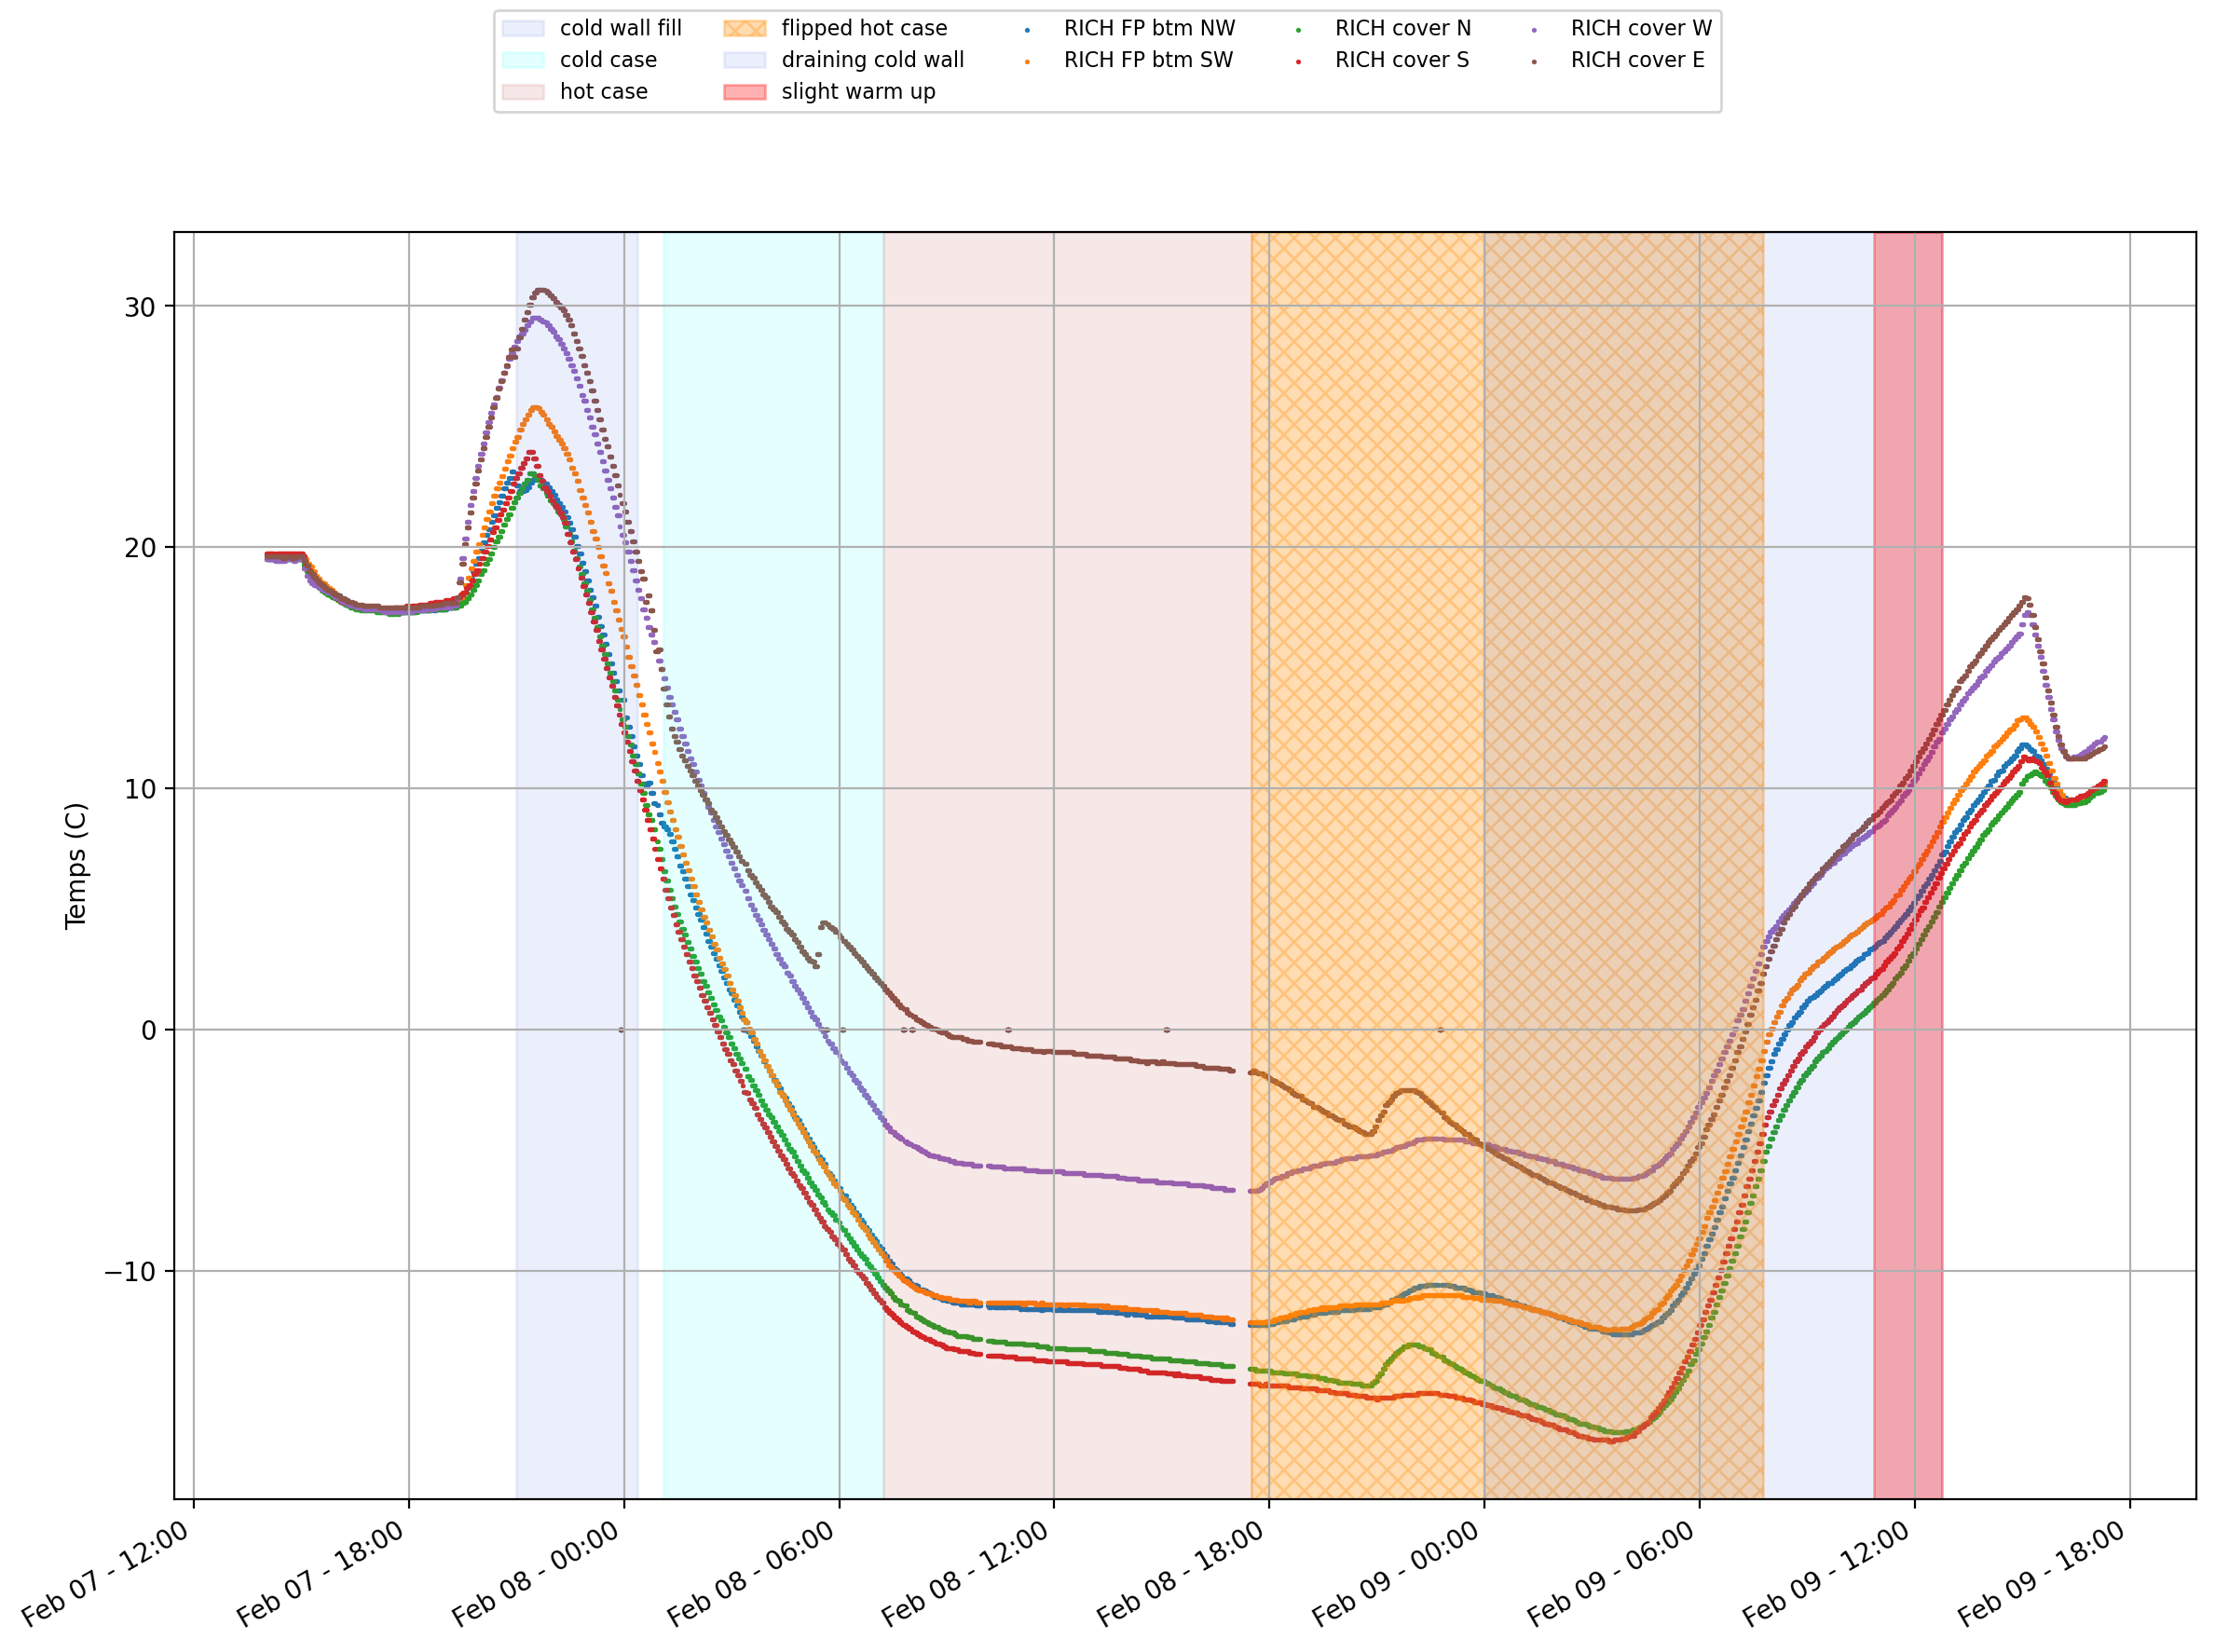

# RICH Masking

In [13]:
#for i in range(0,len(mainhsk_temps_array[:,17])):
 #   if mainhsk_temps_array[i,17] == 0:
  #      print(i, mainhsk_temps_array[i,17])

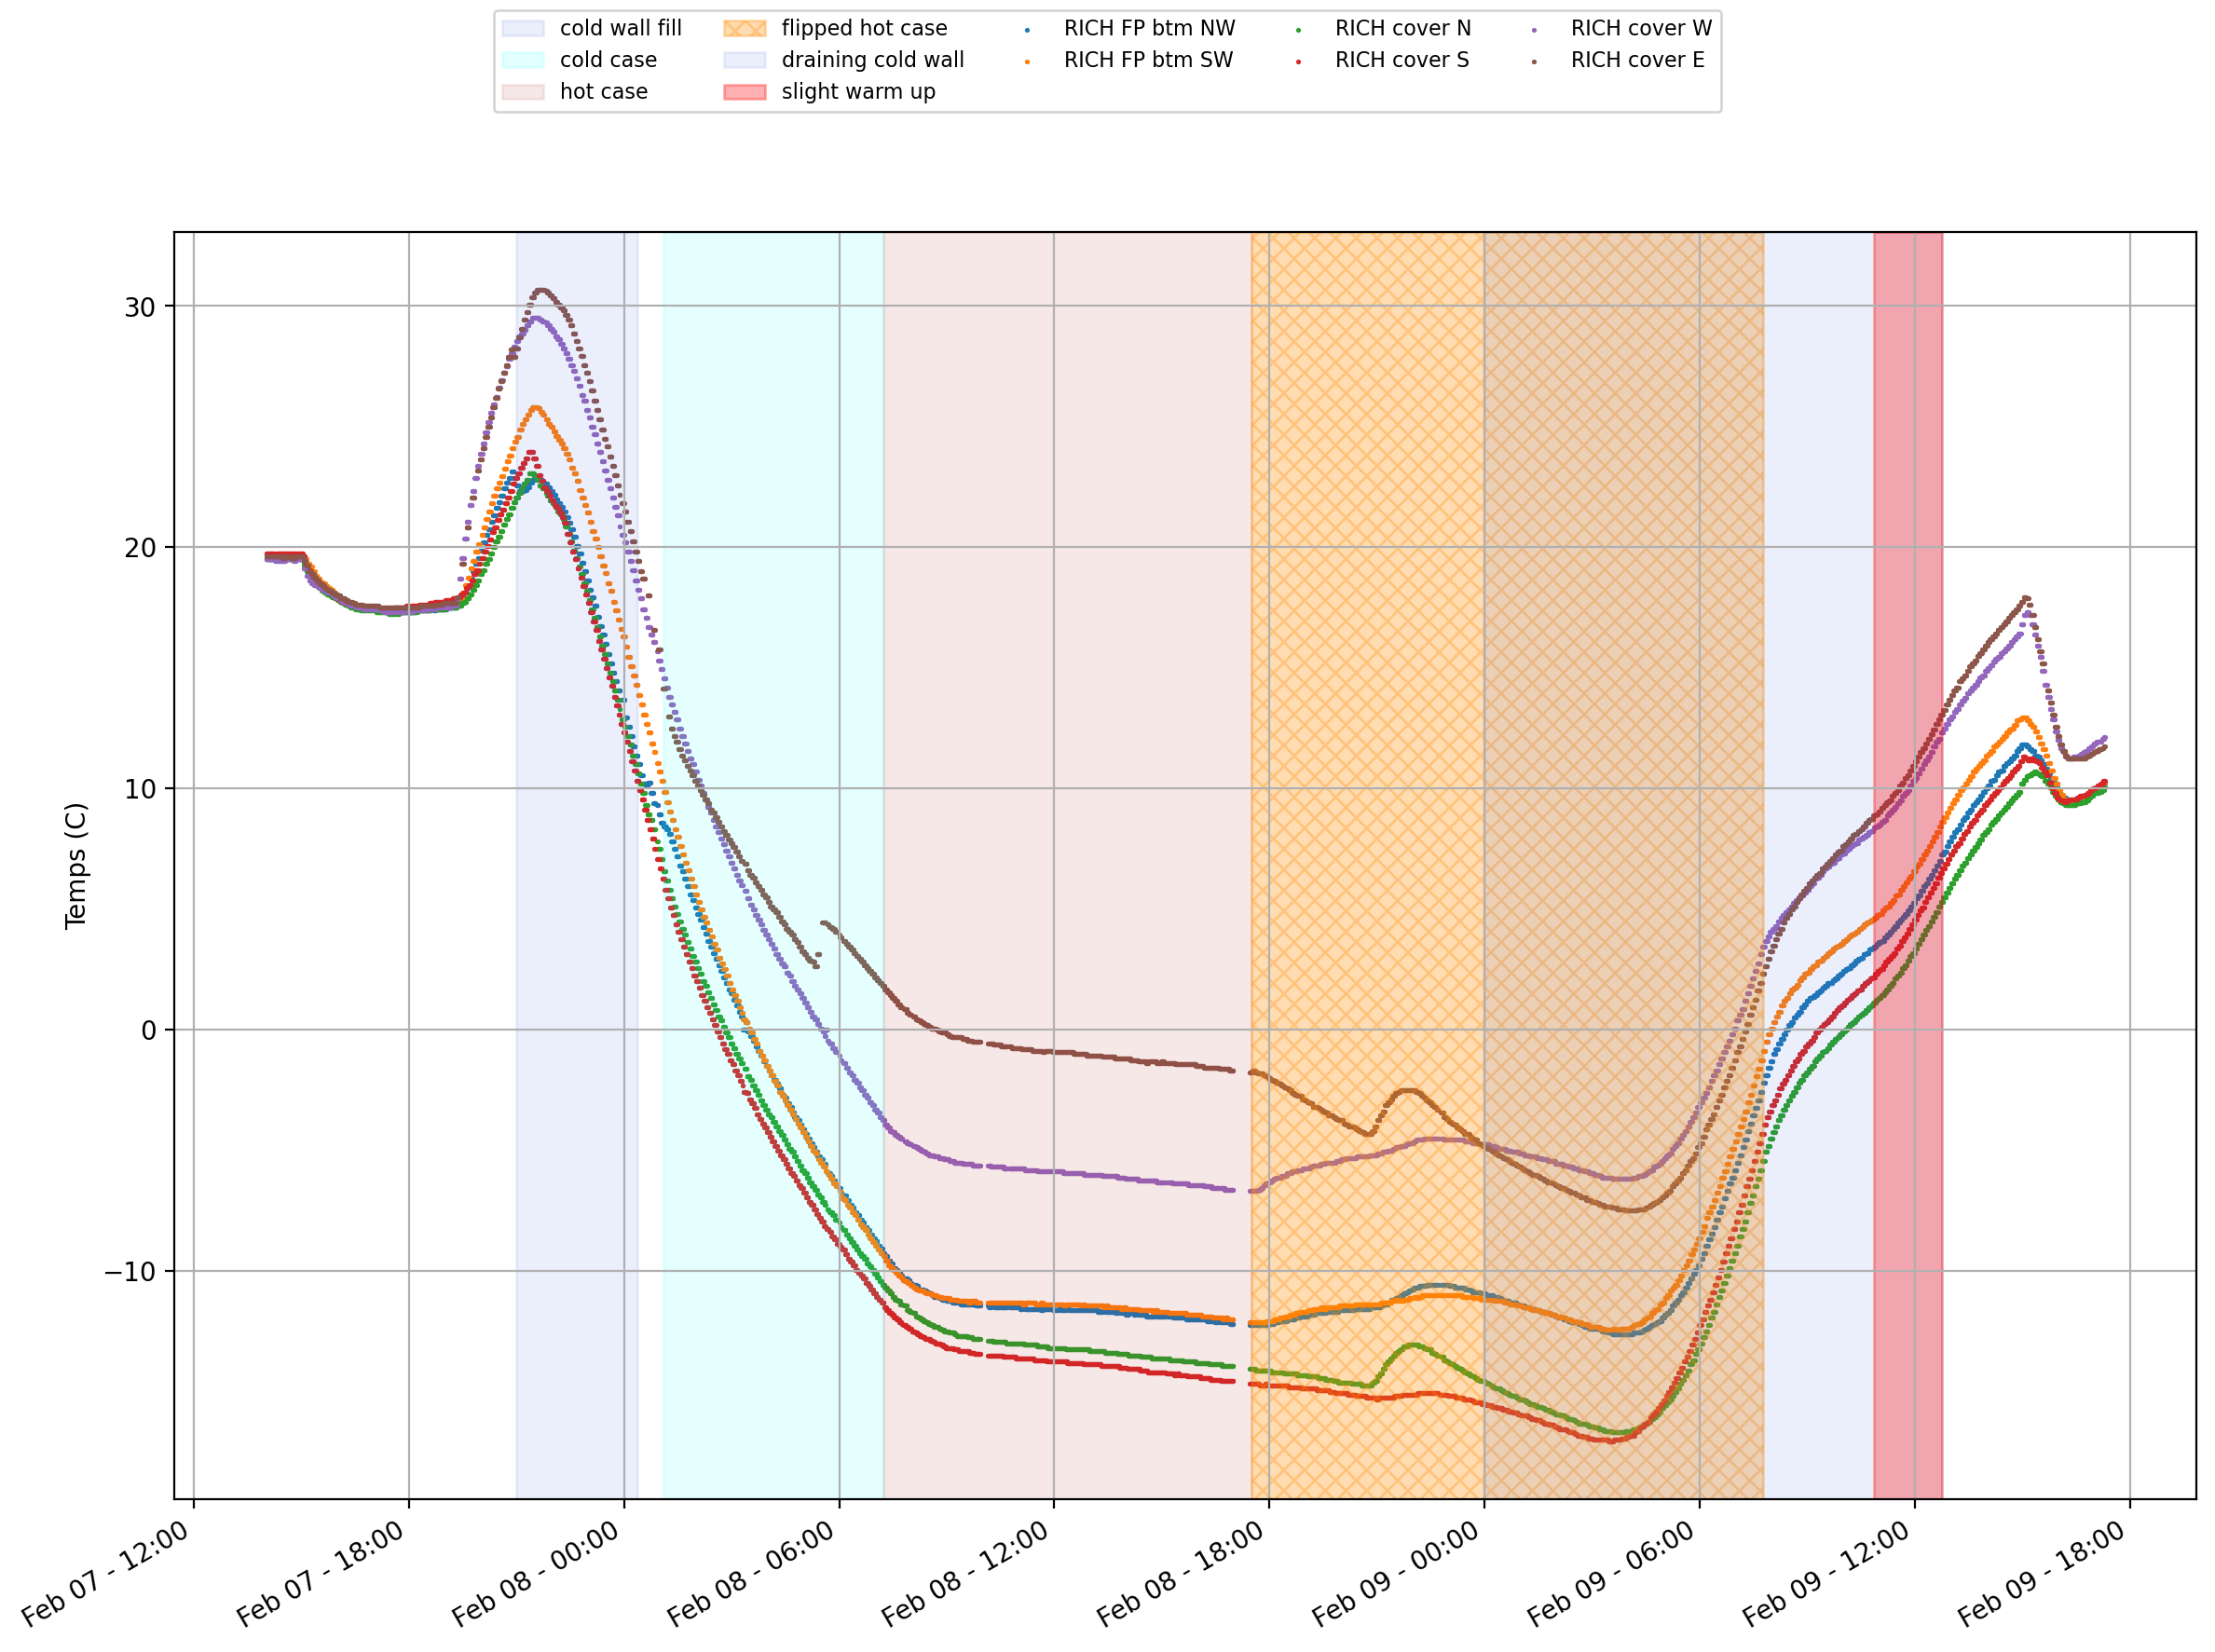

In [30]:
Test = np.copy(Masking(17,1))
print(mainhsk_temps_array[1176, 17], mainhsk_temps_array[1181, 17])
#for i in range(0,6047):
    #if Test[i] == 0:
        #print(i, Test[i], mainhsk_temps_array[i, 17], Test[i-1])
        
for i in range(2110, 2119):
    print(mainhsk_temps_array[i,17])

22.1875 21.8125
0.9375
0.9375
0.0
0.0
0.0
0.0
0.0
0.875
0.875


# North Side Across Foam

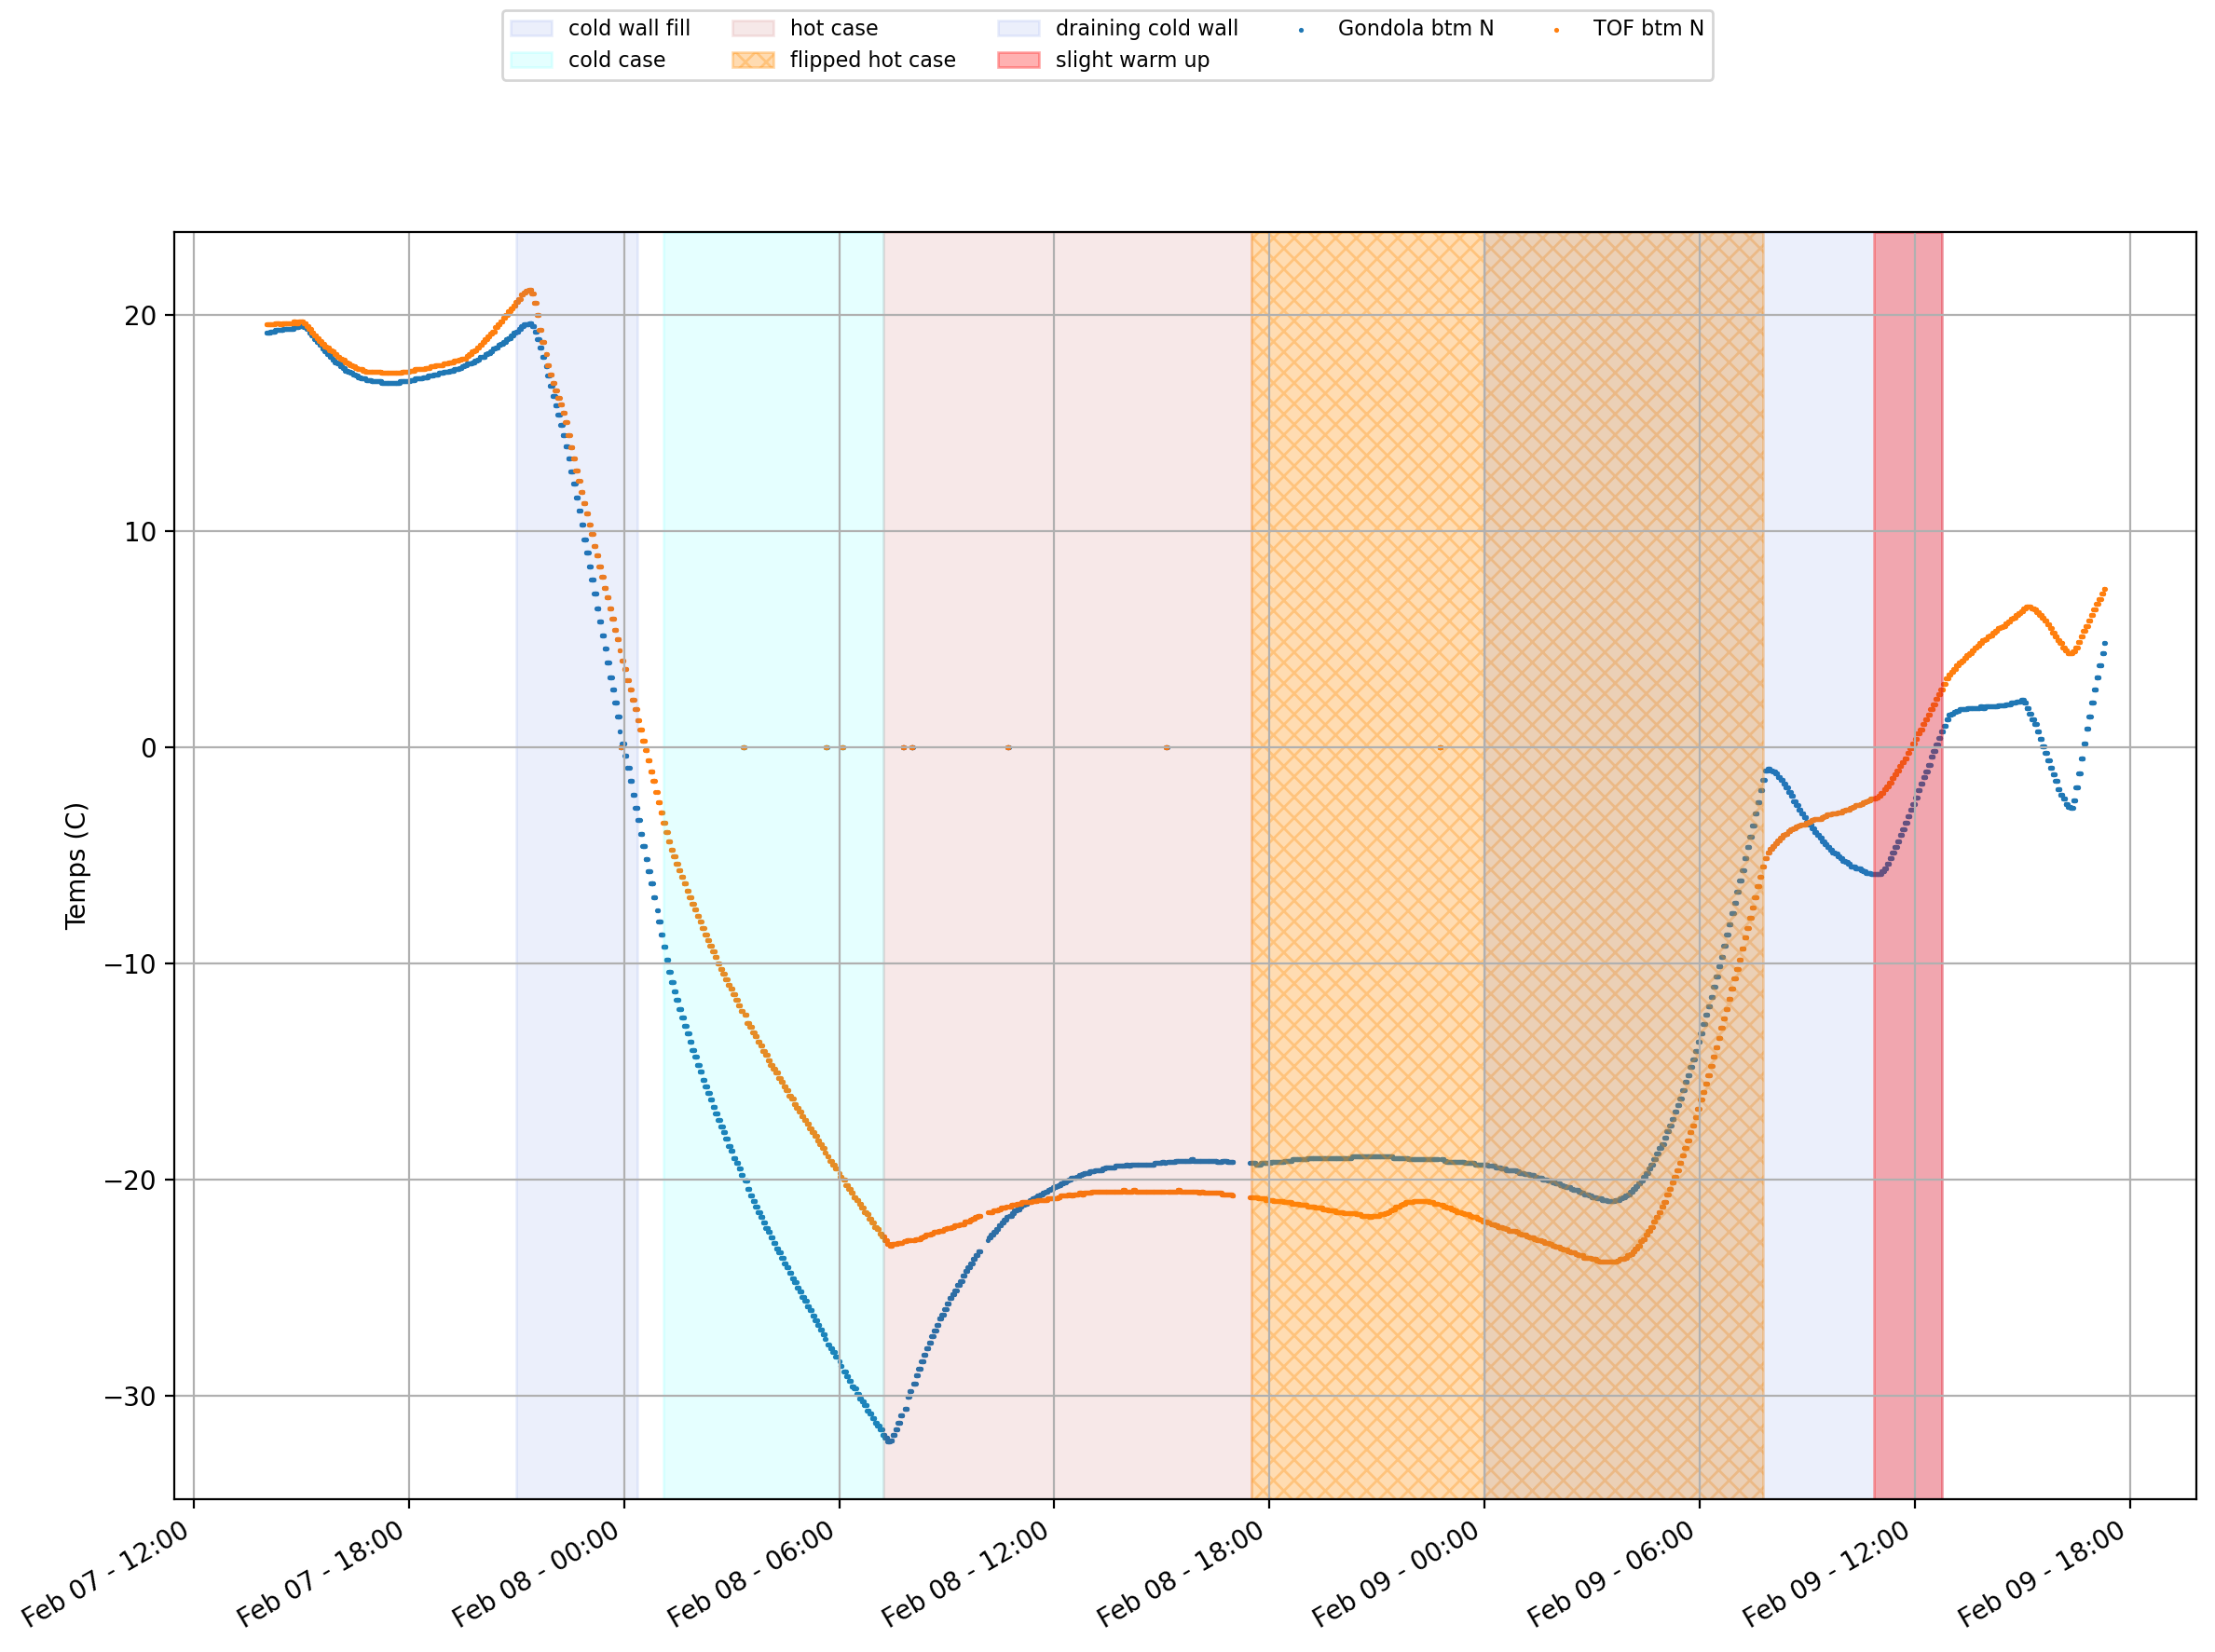

# Masked North Side Across Foam

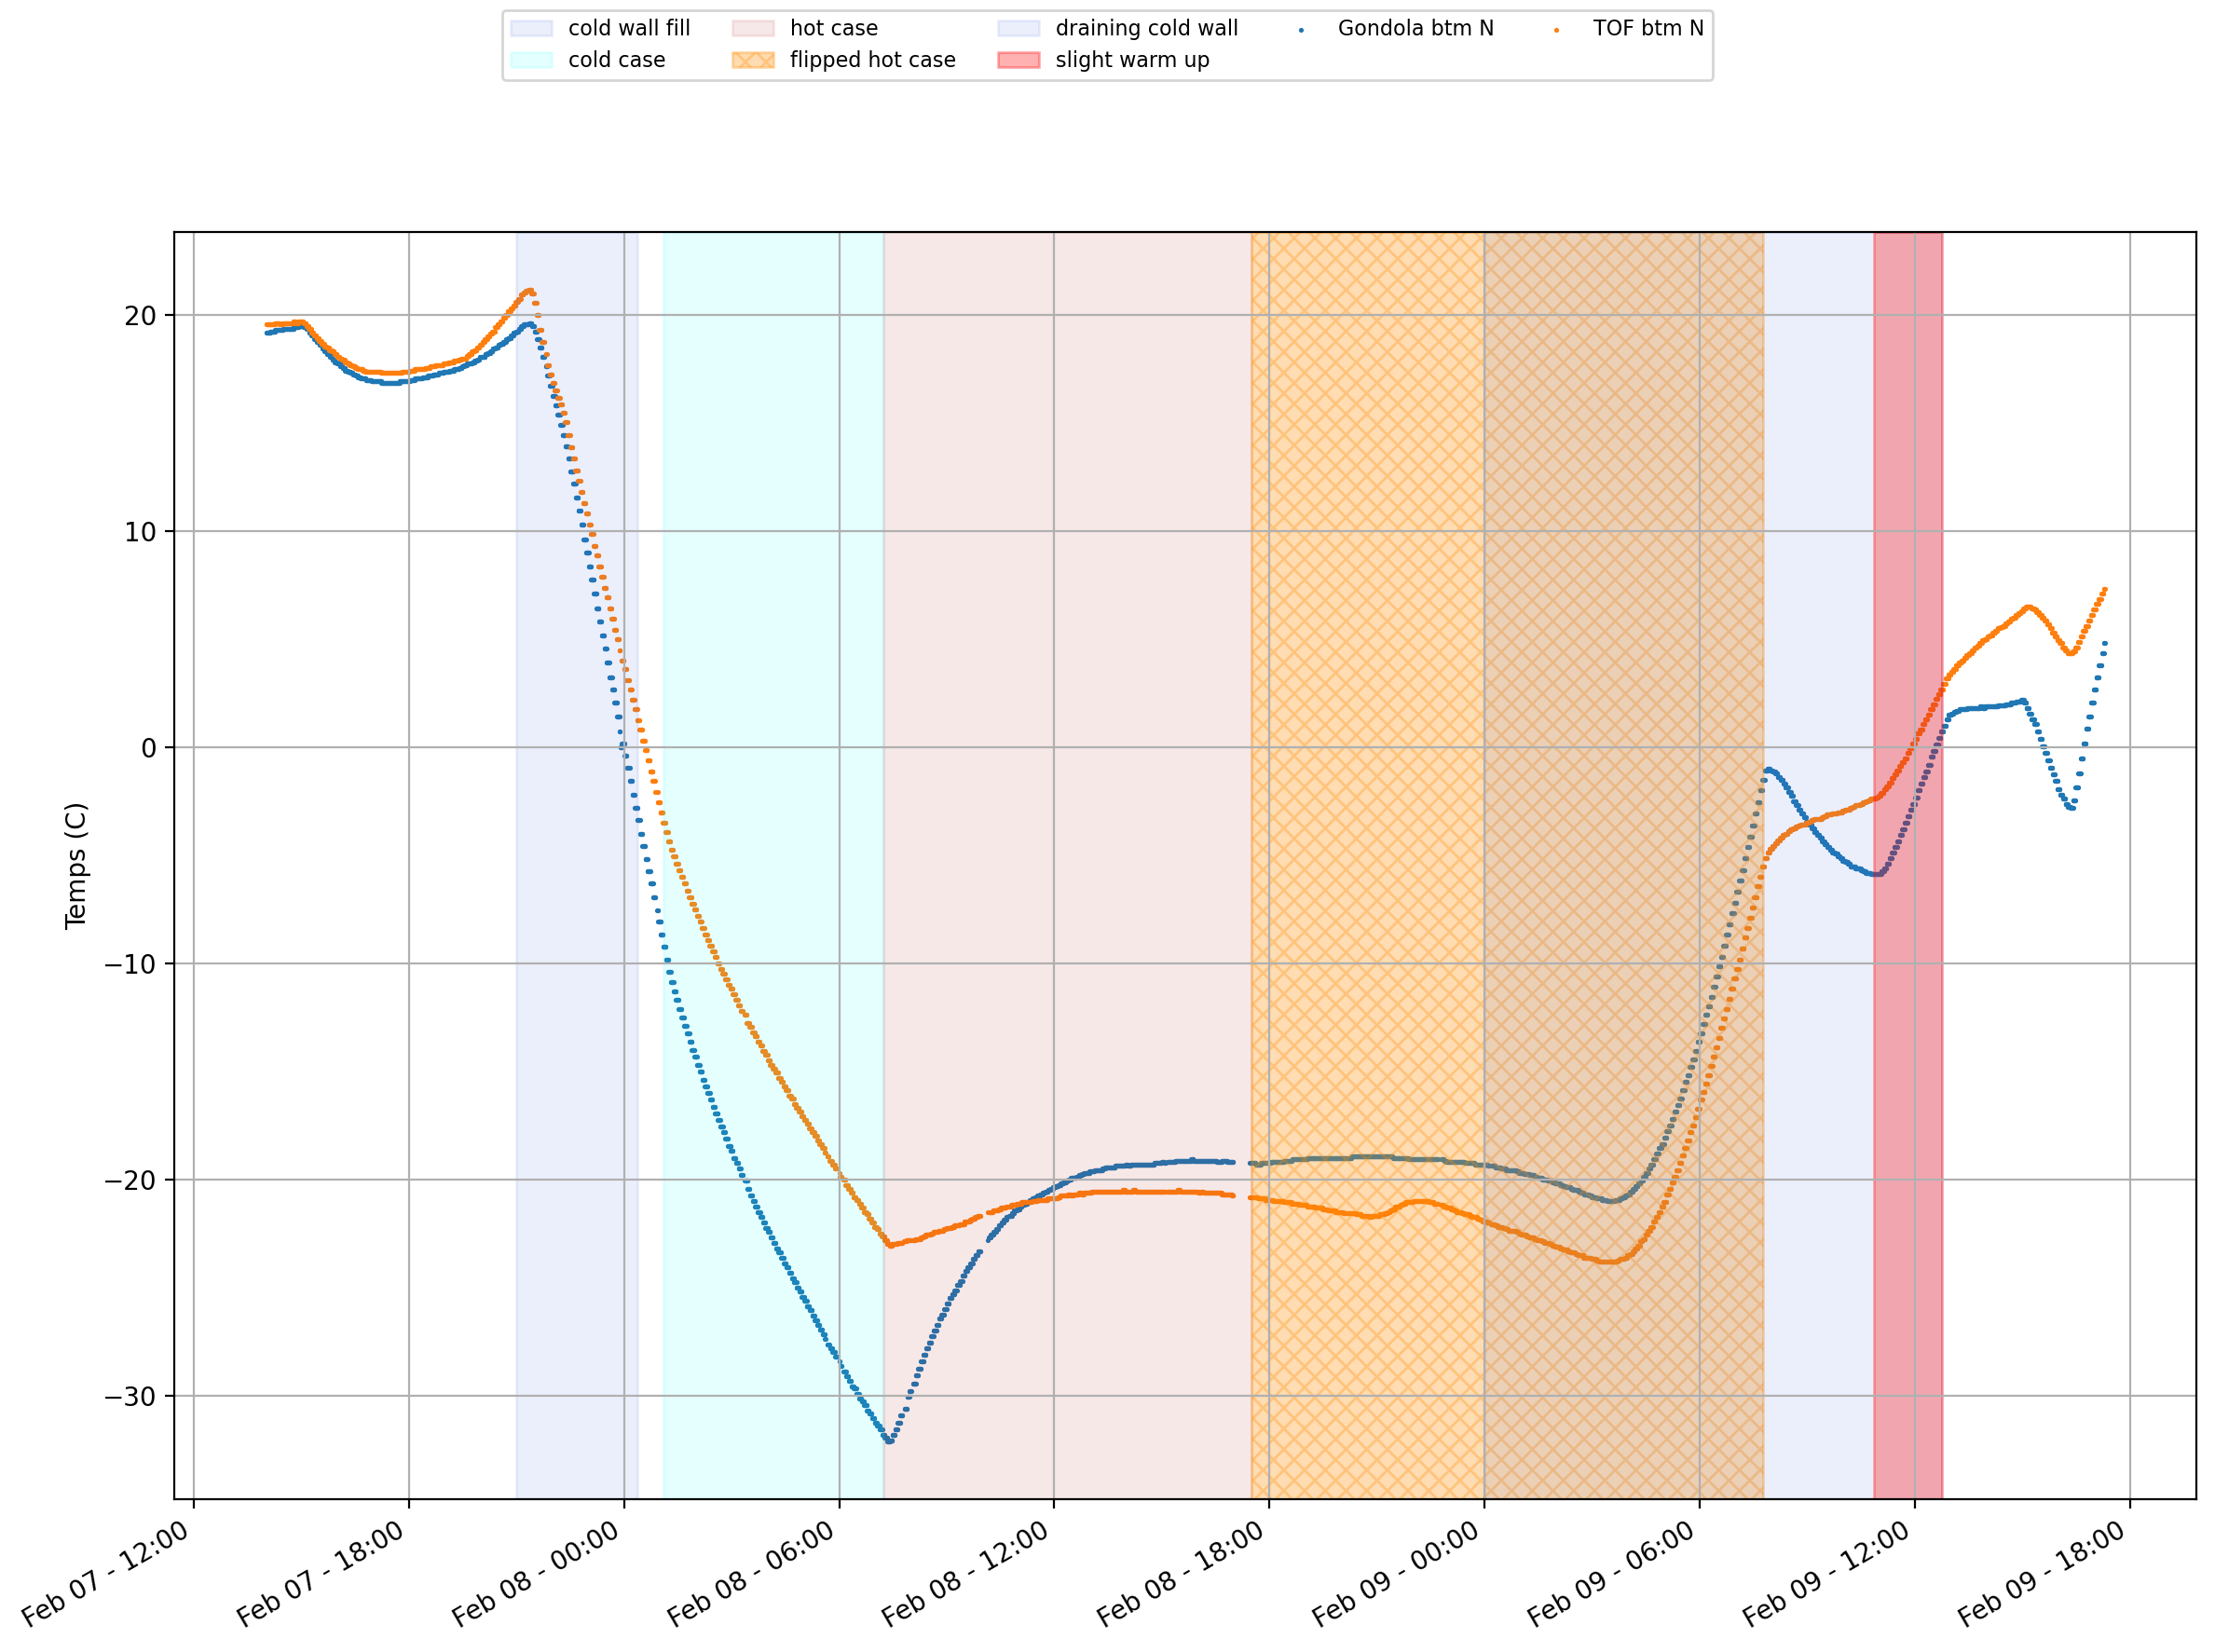

# Misc 1 Interesting Areas

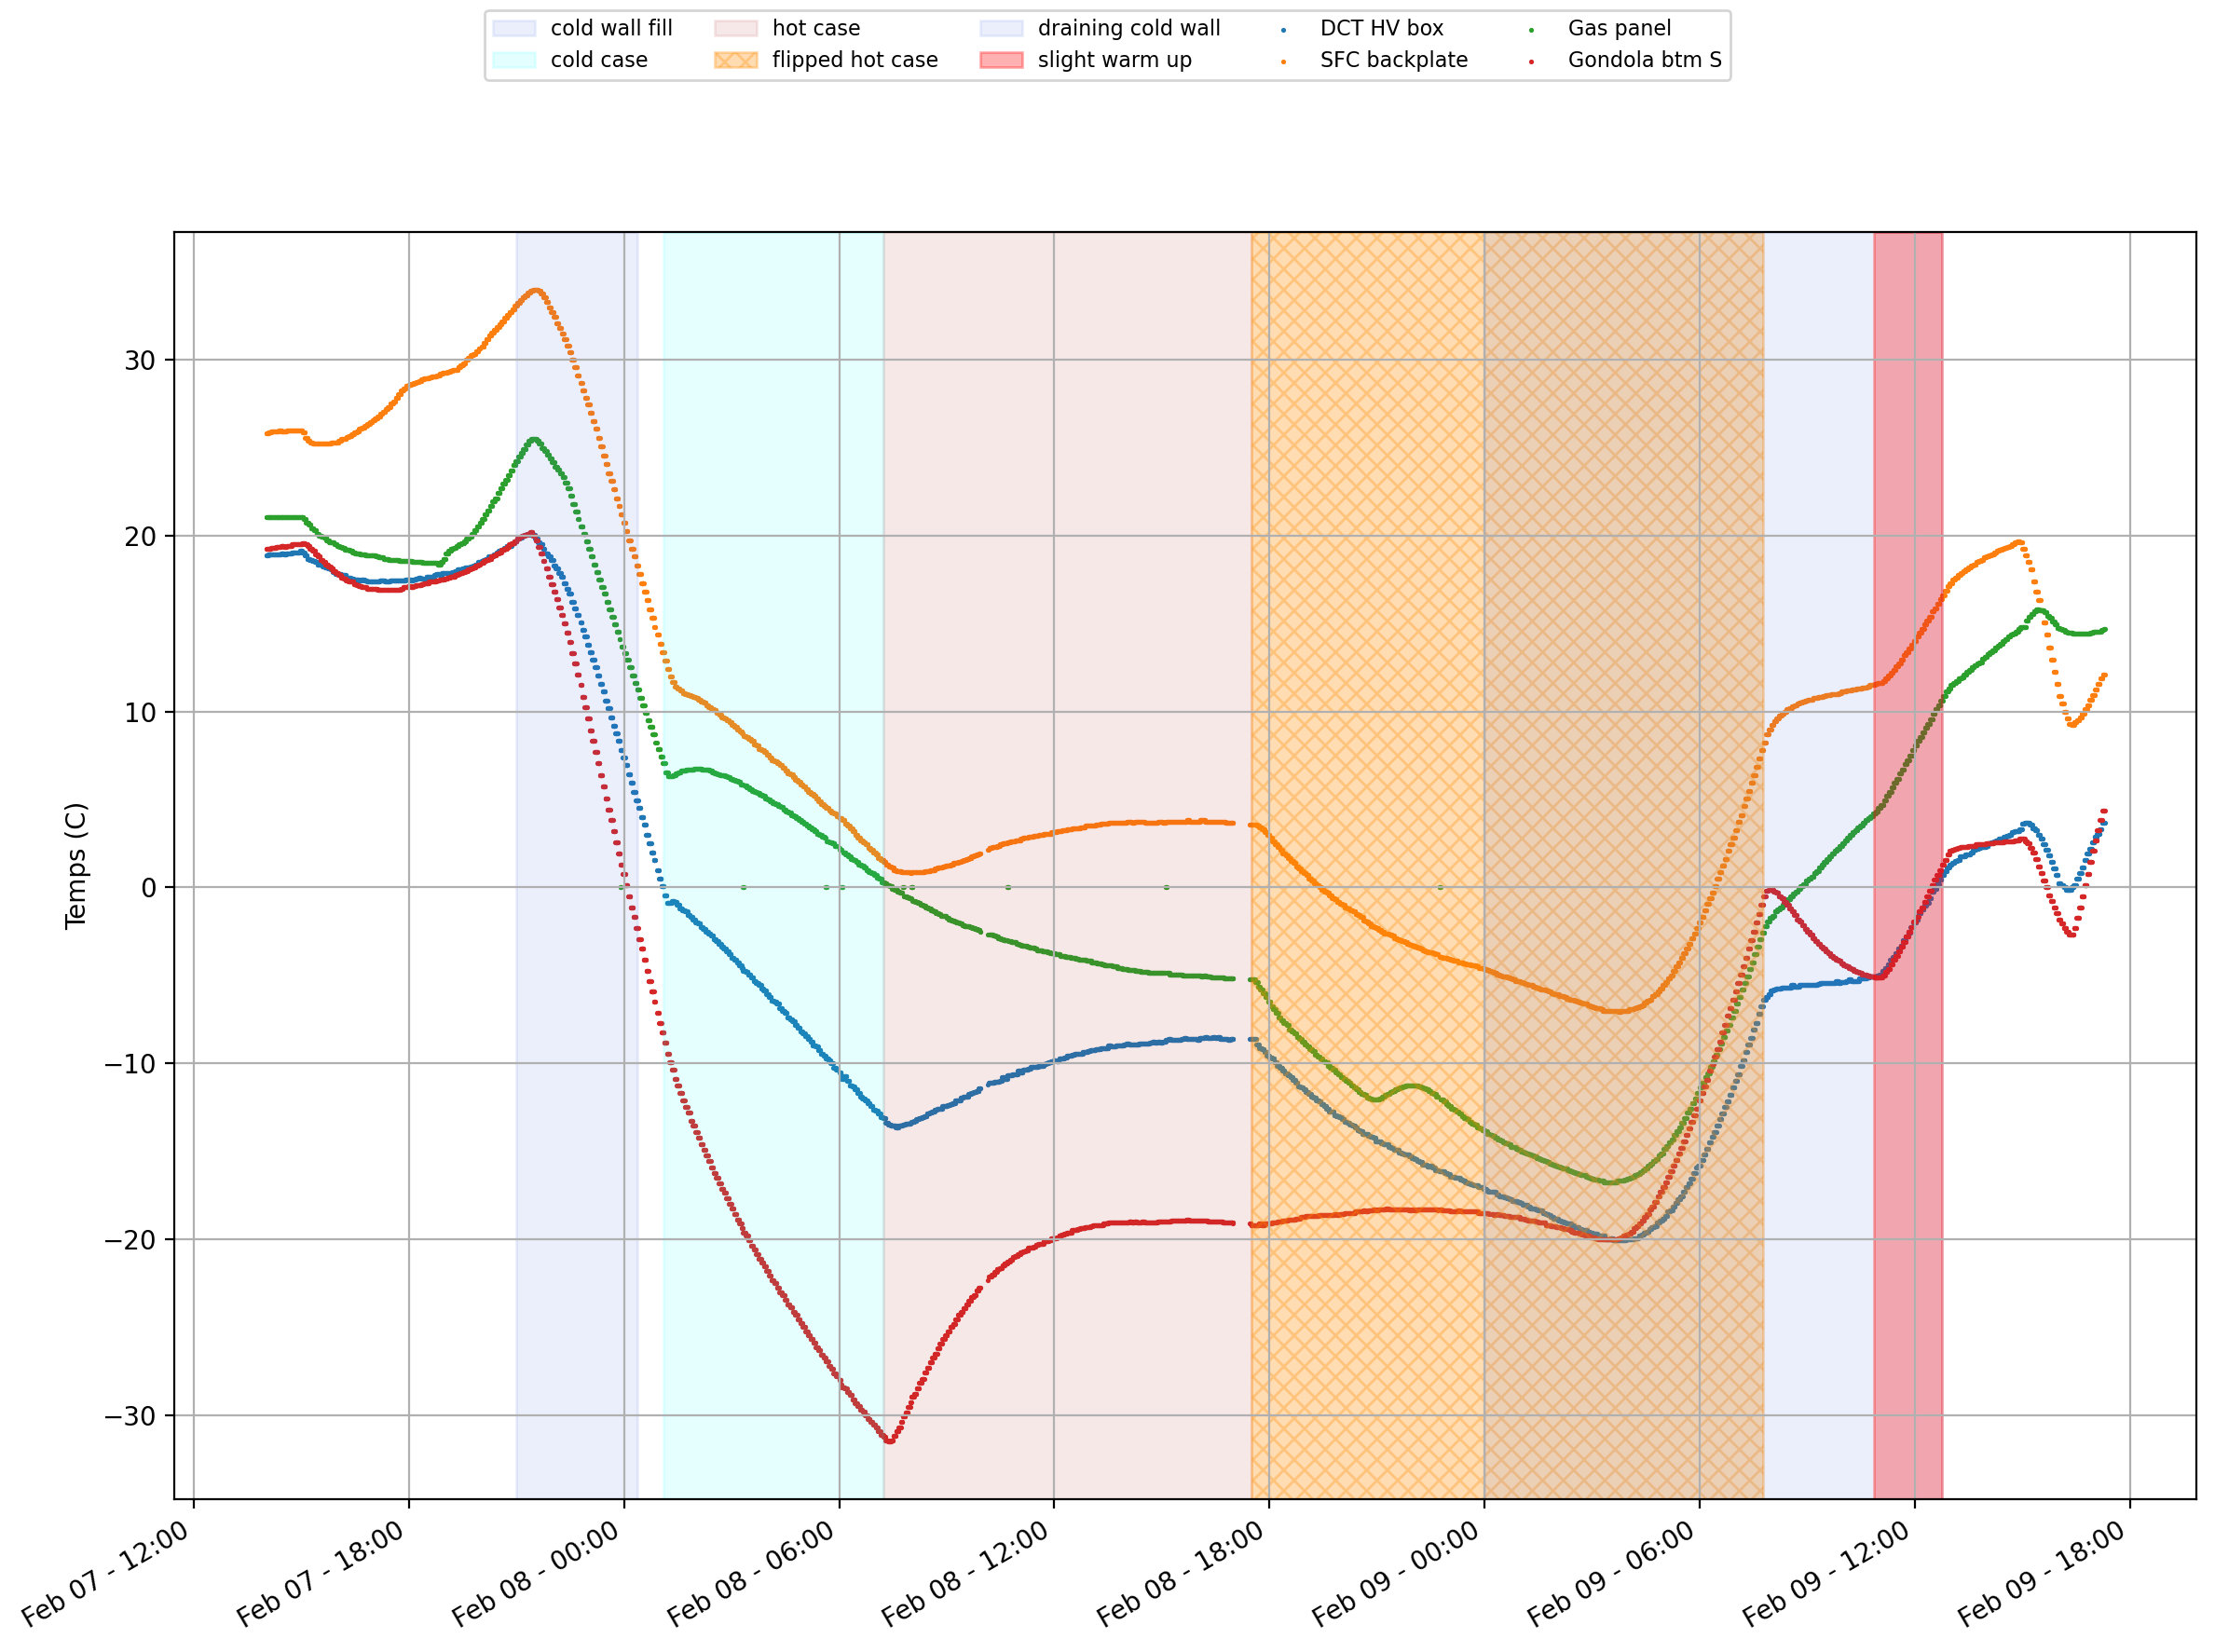

In [44]:
# Now make a plot
fig = plt.figure(figsize=(14, 10), dpi=200)
axs=fig.add_subplot(111)
gs = fig.add_gridspec(1, 1)
#axs = gs.subplots(sharex=True, sharey=False)
#axs = gs.subplots()
#axs.scatter(times, pressure, marker='.')
#axs.set_ylabel("Pressure (Torr)")
#axs.set_ylim([1, 759])


# need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2017, 11, 28, 23, 55, 59, 342380)
cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
power_on_DAQ = times[start_power]
cold_case_start=datetime(2022, 2, 8,1,6,0,0)
cold_case_end=datetime(2022, 2, 8,7,14,0,0)
hot_case_start=cold_case_end
hot_case_end=datetime(2022, 2, 8,17,30,0,0)
kickflip_start=hot_case_end
discharge_magnet = datetime(2022,2,8,20,35,0,0)
discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
#kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
kickflip_end=datetime(2022,2,9,7,46,0,0)
slight_warmup_start=datetime(2022,2,9,10,52,0,0)
drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
slight_warmup_end=datetime(2022,2,9,12,45,0,0)
evacuation_start = datetime(2022,2,7,17,45,0,0)
evacuation_end = datetime(2022,2,9,17,00,0,0)
DAQ_Run = datetime(2022,2,8,5,41,0,0)
DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
heater_start=datetime(2022,2,8,13,18,0,0)
heater_max=datetime(2022,2,8,18,52,0,0)

# hatches for timespans
axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")


#size for markers visibility
s0=3

#misc 1 interesting areas
axs.scatter(times, mainhsk_temps_array[:,2], marker='.',s=s0,label=mainhsk_names.Location.values[2]) # DCT HV box
axs.scatter(times, mainhsk_temps_array[:,6], marker='.',s=s0,label=mainhsk_names.Location.values[6]) # SFC backplate
axs.scatter(times, mainhsk_temps_array[:,15], marker='.',s=s0,label=mainhsk_names.Location.values[15]) # Gas panel
axs.scatter(times, mainhsk_temps_array[:,3], marker='.',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm South
#axs[1].scatter(times, dctboxtemp, marker='.',s=s0,label="DCT box internal temp") # dctbox temp
#axs[1].set_ylim([-50, 38])


axs.set_ylabel("Temps (C)")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
plt.gcf().autofmt_xdate()
#axs[0].grid()
axs.grid()
#plt.legend(loc='upper center', fontsize=8)
handles, labels = axs.get_legend_handles_labels()
#lgd = axs[1].legend(handles, labels)
#for legend_handle in lgd.legendHandles:
#    legend_handle.set_sizes([20])
#labels[6]._legmarker.set_markersize(6)
lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
# as many of these as axs[1].scatter above

plt.show()

# Masked Misc 1 Interesting areas

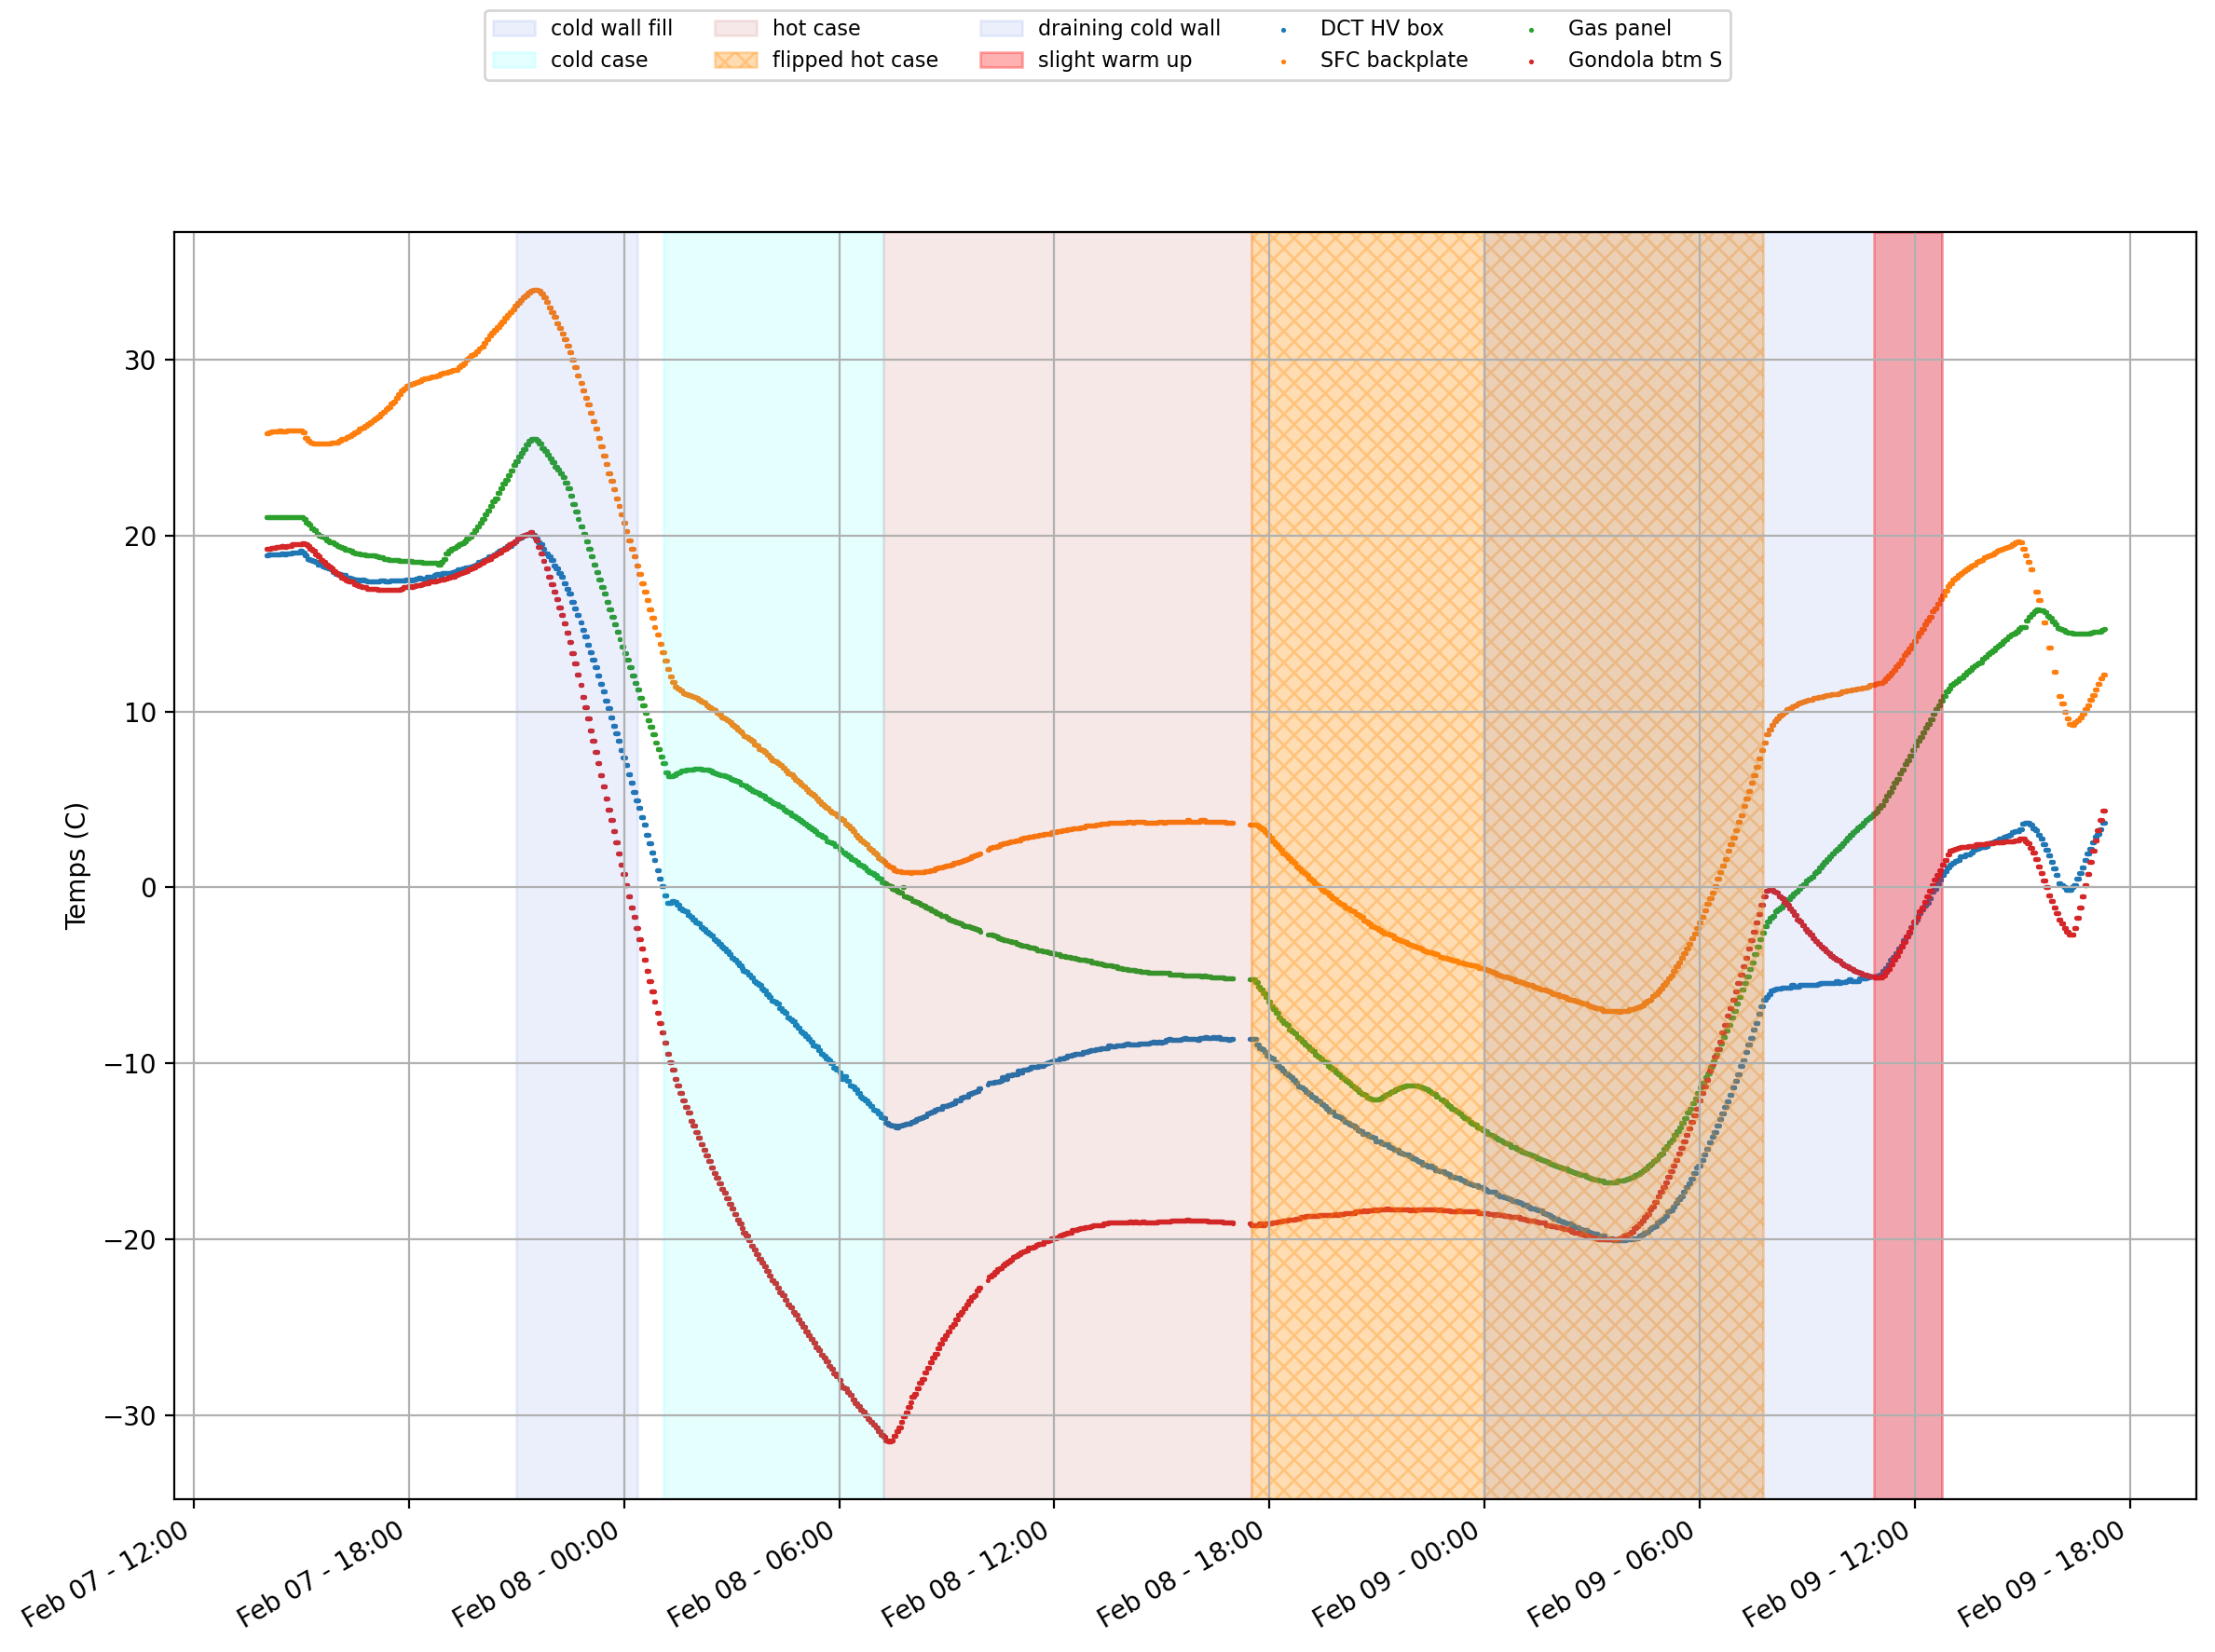

In [64]:
# Now make a plot
fig = plt.figure(figsize=(14, 10), dpi=200)
axs=fig.add_subplot(111)
gs = fig.add_gridspec(1, 1)
#axs = gs.subplots(sharex=True, sharey=False)
#axs = gs.subplots()
#axs.scatter(times, pressure, marker='.')
#axs.set_ylabel("Pressure (Torr)")
#axs.set_ylim([1, 759])


# need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2017, 11, 28, 23, 55, 59, 342380)
cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
power_on_DAQ = times[start_power]
cold_case_start=datetime(2022, 2, 8,1,6,0,0)
cold_case_end=datetime(2022, 2, 8,7,14,0,0)
hot_case_start=cold_case_end
hot_case_end=datetime(2022, 2, 8,17,30,0,0)
kickflip_start=hot_case_end
discharge_magnet = datetime(2022,2,8,20,35,0,0)
discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
#kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
kickflip_end=datetime(2022,2,9,7,46,0,0)
slight_warmup_start=datetime(2022,2,9,10,52,0,0)
drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
slight_warmup_end=datetime(2022,2,9,12,45,0,0)
evacuation_start = datetime(2022,2,7,17,45,0,0)
evacuation_end = datetime(2022,2,9,17,00,0,0)
DAQ_Run = datetime(2022,2,8,5,41,0,0)
DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
heater_start=datetime(2022,2,8,13,18,0,0)
heater_max=datetime(2022,2,8,18,52,0,0)

# hatches for timespans
axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")


#size for markers visibility
s0=3

#misc 1 interesting areas
axs.scatter(times, Masking(2,1), marker='.',s=s0,label=mainhsk_names.Location.values[2]) # DCT HV box
axs.scatter(times, Masking(6,.5), marker='.',s=s0,label=mainhsk_names.Location.values[6]) # SFC backplate
axs.scatter(times, Masking(15,.5), marker='.',s=s0,label=mainhsk_names.Location.values[15]) # Gas panel
axs.scatter(times, Masking(3,1), marker='.',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm South
#axs[1].scatter(times, dctboxtemp, marker='.',s=s0,label="DCT box internal temp") # dctbox temp
#axs[1].set_ylim([-50, 38])


axs.set_ylabel("Temps (C)")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
plt.gcf().autofmt_xdate()
#axs[0].grid()
axs.grid()
#plt.legend(loc='upper center', fontsize=8)
handles, labels = axs.get_legend_handles_labels()
#lgd = axs[1].legend(handles, labels)
#for legend_handle in lgd.legendHandles:
#    legend_handle.set_sizes([20])
#labels[6]._legmarker.set_markersize(6)
lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
# as many of these as axs[1].scatter above

plt.show()

In [80]:
mainhsk_temp_sensors = pd.read_csv('mainhsk_temp_sensors.txt')
print(type(mainhsk_temp_sensors))
mainhsk_temp_sensors

<class 'pandas.core.frame.DataFrame'>


Location  Array index
0                   RICH FP btm SW            0
1                         DCTV top            1
2                       DCT HV box            2
3                    Gondola btm S            3
4                    Gondola btm W            4
5                        TOF btm S            5
6                    SFC backplate            6
7                        TOF top S            7
8                    Gondola mid S            8
9                     RICH cover S            9
10         DCTV bottom/Bore paddle           10
11       bore paddle readout board           11
12       TOF top E-FEE thermal bar           12
13  Gondola mid E on RICH heatsink           13
14  Gondola mid W on RICH heatsink           14
15                       Gas panel           15
16                       TOF btm N           16
17                    RICH cover E           17
18                    RICH cover N           18
19                    RICH cover W           19
20                   Gondola btm N           20
21                       TOF top N           21
22                       TOF btm W           22
23                  RICH FP btm NW           23
24       TOF top W-FEE thermal bar           24
25                       TOF btm E           25

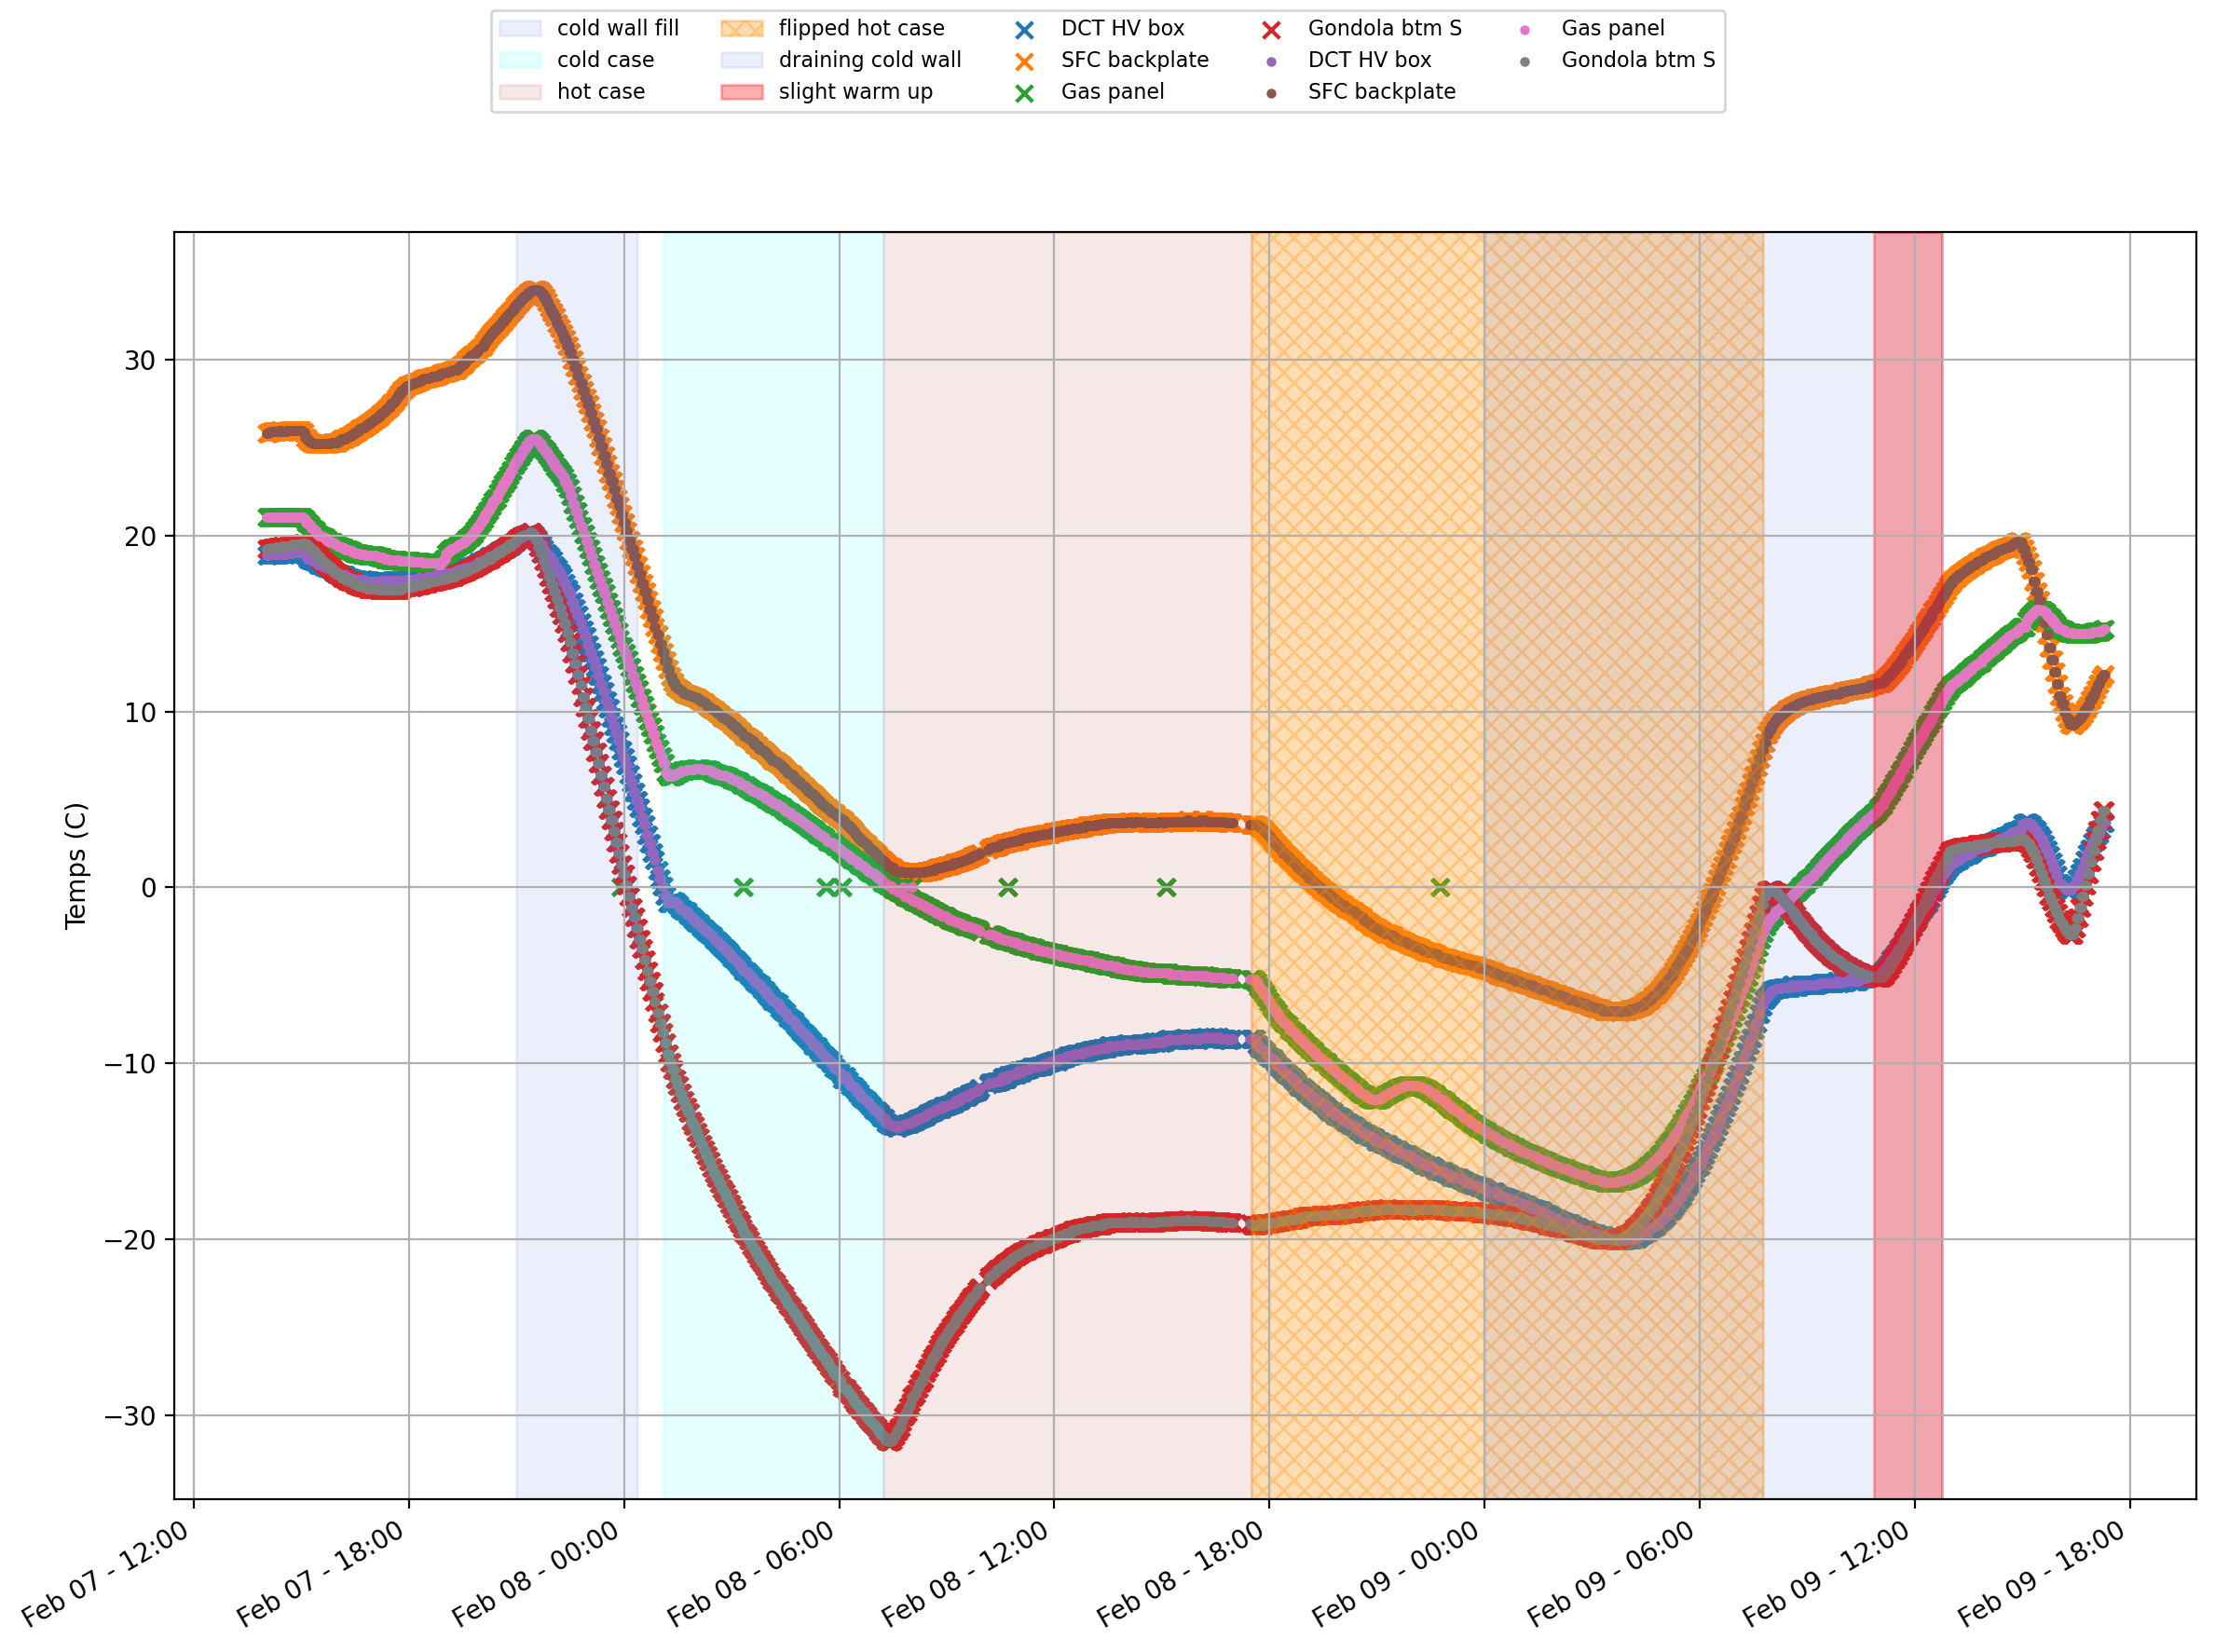

In [73]:
# Now make a plot
fig = plt.figure(figsize=(14, 10), dpi=200)
axs=fig.add_subplot(111)
gs = fig.add_gridspec(1, 1)
#axs = gs.subplots(sharex=True, sharey=False)
#axs = gs.subplots()
#axs.scatter(times, pressure, marker='.')
#axs.set_ylabel("Pressure (Torr)")
#axs.set_ylim([1, 759])


# need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2017, 11, 28, 23, 55, 59, 342380)
cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
power_on_DAQ = times[start_power]
cold_case_start=datetime(2022, 2, 8,1,6,0,0)
cold_case_end=datetime(2022, 2, 8,7,14,0,0)
hot_case_start=cold_case_end
hot_case_end=datetime(2022, 2, 8,17,30,0,0)
kickflip_start=hot_case_end
discharge_magnet = datetime(2022,2,8,20,35,0,0)
discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
#kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
kickflip_end=datetime(2022,2,9,7,46,0,0)
slight_warmup_start=datetime(2022,2,9,10,52,0,0)
drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
slight_warmup_end=datetime(2022,2,9,12,45,0,0)
evacuation_start = datetime(2022,2,7,17,45,0,0)
evacuation_end = datetime(2022,2,9,17,00,0,0)
DAQ_Run = datetime(2022,2,8,5,41,0,0)
DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
heater_start=datetime(2022,2,8,13,18,0,0)
heater_max=datetime(2022,2,8,18,52,0,0)

# hatches for timespans
axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")


#size for markers visibility
s0=40
sM = 30


# south here : seq=1
#axs.scatter(times, mainhsk_temps_array[:,7], marker='x',s=s0,label=mainhsk_names.Location.values[7]) # TOF top South
#axs.scatter(times, mainhsk_temps_array[:,5], marker='x',s=s0,label=mainhsk_names.Location.values[5]) # TOF btm south
#axs.scatter(times, mainhsk_temps_array[:,3], marker='x',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm south
#axs.scatter(times, mainhsk_temps_array[:,8], marker='x',s=s0,label=mainhsk_names.Location.values[8]) # gondola mid South
#axs.scatter(NASA_TCs[13]['Times'], NASA_TCs[13]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[13]) # SoFr is on the gondola I believe
#axs.scatter(NASA_TCs[1]['Times'], NASA_TCs[1]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[1]) # In South is on foam inside gondola
#axs.scatter(NASA_TCs[7]['Times'], NASA_TCs[7]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[7]) # SoUp is on foam outside gondola
#axs.scatter(NASA_TCs[8]['Times'], NASA_TCs[8]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[8]) # SoUp is on foam outside gondola
#axs.set_ylim([-50, 33])
#axs.set_xlim([times.values[0],times.values[-1]])

#Masked Version
#axs.scatter(times, Masking(7,3), marker='.',s=sM,label=mainhsk_names.Location.values[7]) # TOF top South
#axs.scatter(times, Masking(5,1), marker='.',s=sM,label=mainhsk_names.Location.values[5]) # TOF btm south
#axs.scatter(times, Masking(3,1), marker='.',s=sM,label=mainhsk_names.Location.values[3]) # gondola btm south
#axs.scatter(times, Masking(8,1), marker='.',s=sM,label=mainhsk_names.Location.values[8]) # gondola mid South


#RICH east or west side
#axs.scatter(times, mainhsk_temps_array[:,13], marker='x',s=s0,label=mainhsk_names.Location.values[13]) # Mid east RICH heatsink
#axs.scatter(times, mainhsk_temps_array[:,17], marker='x',s=s0,label=mainhsk_names.Location.values[17]) # RICH cover E
#axs.scatter(NASA_TCs[0]['Times'], NASA_TCs[0]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[0]) # InEast is on foam inside foam
#axs.scatter(NASA_TCs[5]['Times'], NASA_TCs[5]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[5]) # EastUp is on foam inside gondola
#axs.scatter(NASA_TCs[6]['Times'], NASA_TCs[6]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[6]) # EastUp is on foam inside gondola
#axs.scatter(times, mainhsk_temps_array[:,14], marker='x',s=s0,label=mainhsk_names.Location.values[14]) # Mid West RICH heatsink
#axs.scatter(times, mainhsk_temps_array[:,19], marker='x',s=s0,label=mainhsk_names.Location.values[19]) # RICH cover E
#axs.scatter(NASA_TCs[9]['Times'], NASA_TCs[9]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[9]) # WestUp is on foam inside gondola
#axs.scatter(NASA_TCs[10]['Times'], NASA_TCs[10]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[10]) # WestLo is on foam inside gondola
#axs.set_ylim([-60, 60])
#axs.set_xlim([times.values[0],times.values[-1]])

#Masked Version
#axs.scatter(times, Masking(13,1), marker='.',s=sM,label=mainhsk_names.Location.values[13]) # Mid east RICH heatsink
#axs.scatter(times, Masking(17,.75), marker='.',s=sM,label=mainhsk_names.Location.values[17]) # RICH cover E
#axs.scatter(times, Masking(14,1), marker='.',s=sM,label=mainhsk_names.Location.values[14]) # Mid West RICH heatsink
#axs.scatter(times, Masking(19,1), marker='.',s=sM,label=mainhsk_names.Location.values[19]) # RICH cover E


#North side across foam
#correct/calibrate the North top TOF sensor
#begin_pumping=datetime(2022,2,7,14,55,0,0)
#times_calibrate=pd.to_datetime(times.values)
#times_range=np.asarray(begin_pumping-times_calibrate).astype('timedelta64[s]')
#times_range = times_range / np.timedelta64(1, 's')
#times_to_consider=np.where(times_range>0)
#TOF_diffs=mainhsk_temps_array[times_to_consider,21]-mainhsk_temps_array[times_to_consider,7]
#average_offset=np.mean(TOF_diffs[0])
#median_offset=np.median(TOF_diffs[0])
#axs.scatter(times, mainhsk_temps_array[:,20], marker='x',s=s0,label=mainhsk_names.Location.values[20]) # Gondola btm north
#axs.scatter(times, mainhsk_temps_array[:,16], marker='x',s=s0,label=mainhsk_names.Location.values[16]) # TOF btm N
#axs.scatter(times, mainhsk_temps_array[:,21]-average_offset, marker='x',s=s0,label=mainhsk_names.Location.values[21]) # TOF top N
#axs.scatter(NASA_TCs[3]['Times'], NASA_TCs[3]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[3]) # NoUp is on foam inside gondola
#axs.scatter(NASA_TCs[4]['Times'], NASA_TCs[4]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[4]) # NoLo is on foam inside gondola
#axs.set_ylim([-80, 30])
#axs.set_xlim([times.values[0],times.values[-1]])

#Masked Version
#axs.scatter(times, Masking(20,1), marker='.',s=sM,label=mainhsk_names.Location.values[20]) # Gondola btm north
#axs.scatter(times, Masking(16,1), marker='.',s=sM,label=mainhsk_names.Location.values[16]) # TOF btm N
#axs.scatter(times, Masking(21,1)-average_offset, marker='.',s=sM,label=mainhsk_names.Location.values[21]) # TOF top N


#misc 1 interesting areas
axs.scatter(times, mainhsk_temps_array[:,2], marker='x',s=s0,label=mainhsk_names.Location.values[2]) # DCT HV box
axs.scatter(times, mainhsk_temps_array[:,6], marker='x',s=s0,label=mainhsk_names.Location.values[6]) # SFC backplate
axs.scatter(times, mainhsk_temps_array[:,15], marker='x',s=s0,label=mainhsk_names.Location.values[15]) # Gas panel
axs.scatter(times, mainhsk_temps_array[:,3], marker='x',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm South
#axs[1].scatter(times, dctboxtemp, marker='.',s=s0,label="DCT box internal temp") # dctbox temp
#axs[1].set_ylim([-50, 38])

#Masking Version
axs.scatter(times, Masking(2,1), marker='.',s=sM,label=mainhsk_names.Location.values[2]) # DCT HV box
axs.scatter(times, Masking(6,1), marker='.',s=sM,label=mainhsk_names.Location.values[6]) # SFC backplate
axs.scatter(times, Masking(15,1), marker='.',s=sM,label=mainhsk_names.Location.values[15]) # Gas panel
axs.scatter(times, Masking(3,1), marker='.',s=sM,label=mainhsk_names.Location.values[3]) # gondola btm South


#RICH
#axs.axvline(x=DAQ_Run,ymin=0, ymax=1, color='red',label="DAQ Run")
#axs.axvline(x=DAQ_Run_2,ymin=0, ymax=1, color='black',label="DAQ Run 2 end")
#axs.scatter(times, mainhsk_temps_array[:,23], marker='x',s=s0,label=mainhsk_names.Location.values[23]) # rich focal plane NW
#axs.scatter(times, mainhsk_temps_array[:,0], marker='x',s=s0,label=mainhsk_names.Location.values[0]) # rich focal plane SW
#axs.scatter(times, mainhsk_temps_array[:,18], marker='x',s=s0,label=mainhsk_names.Location.values[18]) # rich cover N
#axs.scatter(times, mainhsk_temps_array[:,9], marker='x',s=s0,label=mainhsk_names.Location.values[9]) # rich cover S
#axs.scatter(times, mainhsk_temps_array[:,19], marker='x',s=s0,label=mainhsk_names.Location.values[19]) # rich cover W
#axs.scatter(times, mainhsk_temps_array[:,17], marker='x',s=s0,label=mainhsk_names.Location.values[17]) # rich cover E
#axs.set_ylim([-20, 39])

#Masked Version
#axs.scatter(times, Masking(23,1), marker='.',s=sM,label=mainhsk_names.Location.values[23]) # rich focal plane NW
#axs.scatter(times, Masking(0,1), marker='.',s=sM,label=mainhsk_names.Location.values[0]) # rich focal plane SW
#axs.scatter(times, Masking(18,1), marker='.',s=sM,label=mainhsk_names.Location.values[18]) # rich cover N
#axs.scatter(times, Masking(9,1), marker='.',s=sM,label=mainhsk_names.Location.values[9]) # rich cover S
#axs.scatter(times, Masking(19,1), marker='.',s=sM,label=mainhsk_names.Location.values[19]) # rich cover W
#axs.scatter(times, Masking(17,1), marker='.',s=sM,label=mainhsk_names.Location.values[17]) # rich cover E


#TOF Fees only
#axs.scatter(times, mainhsk_temps_array[:,12], marker='x',s=s0,label=mainhsk_names.Location.values[12]) 
#axs.scatter(times, mainhsk_temps_array[:,22], marker='x',s=s0,label=mainhsk_names.Location.values[22]) 
#axs.scatter(times, mainhsk_temps_array[:,24], marker='x',s=s0,label=mainhsk_names.Location.values[24]) 
#axs.scatter(times, mainhsk_temps_array[:,25], marker='x',s=s0,label=mainhsk_names.Location.values[25])

#Masked Version
#axs.scatter(times, Masking(12,2), marker='.',s=sM,label=mainhsk_names.Location.values[12]) 
#axs.scatter(times, Masking(22,1), marker='.',s=sM,label=mainhsk_names.Location.values[22]) 
#axs.scatter(times, Masking(24,2), marker='.',s=sM,label=mainhsk_names.Location.values[24]) 
#axs.scatter(times, Masking(25,1), marker='.',s=sM,label=mainhsk_names.Location.values[25])


#Gondola Bottom
#axs.scatter(times, mainhsk_temps_array[:,3], marker='x',s=s0,label=mainhsk_names.Location.values[3]) 
#axs.scatter(times, mainhsk_temps_array[:,4], marker='x',s=s0,label=mainhsk_names.Location.values[4]) 
#axs.scatter(times, mainhsk_temps_array[:,20], marker='x',s=s0,label=mainhsk_names.Location.values[20]) 
#axs.scatter(times, mainhsk_temps_array[:,2], marker='x',s=s0,label=mainhsk_names.Location.values[2])

#Masked Version
#axs.scatter(times, Masking(3,1), marker='.',s=sM,label=mainhsk_names.Location.values[3]) 
#axs.scatter(times, Masking(4,1), marker='.',s=sM,label=mainhsk_names.Location.values[4]) 
#axs.scatter(times, Masking(20,1), marker='.',s=sM,label=mainhsk_names.Location.values[20]) 
#axs.scatter(times, Masking(2,1), marker='.',s=sM,label=mainhsk_names.Location.values[2])


#bore paddle stuff
#axs.scatter(times, mainhsk_temps_array[:,10], marker='x',s=s0,label=mainhsk_names.Location.values[10]) 
#axs.scatter(times, mainhsk_temps_array[:,11], marker='x',s=s0,label=mainhsk_names.Location.values[11])

#axs.scatter(times, Masking(10,1), marker='.',s=sM,label=mainhsk_names.Location.values[10]) 
#axs.scatter(times, Masking(11,1.5), marker='.',s=sM,label=mainhsk_names.Location.values[11])





axs.set_ylabel("Temps (C)")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
plt.gcf().autofmt_xdate()
#axs[0].grid()
axs.grid()
#plt.legend(loc='upper center', fontsize=8)
handles, labels = axs.get_legend_handles_labels()
#lgd = axs[1].legend(handles, labels)
#for legend_handle in lgd.legendHandles:
#    legend_handle.set_sizes([20])
#labels[6]._legmarker.set_markersize(6)
lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
# as many of these as axs[1].scatter above

plt.show()

In [22]:
#size for markers visibility
s0=3
#temp data goes here

#across foam
#axs.scatter(NASA_TCs[1]['Times'], NASA_TCs[1]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[1]) # In South is on foam inside gondola
#axs.scatter(NASA_TCs[8]['Times'], NASA_TCs[8]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[8]) # SoLo is on foam outside gondola
#axs.scatter(NASA_TCs[0]['Times'], NASA_TCs[0]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[0]) # InEast is on foam inside foam
#axs.scatter(NASA_TCs[6]['Times'], NASA_TCs[6]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[6]) # EastLo is on foam inside gondola
#axs.set_ylim([-80, 30])
#axs.set_xlim([times.values[0],times.values[-1]])

In [38]:
#NASA TCs
iter=0
while iter<len(NASA_TCs):
    #print(len(NASA_TCs[iter]['Times'].values))
    #print(len(NASA_TCs[iter]['Value'].values))
    #print(NASA_names[iter]['Times'].values))
    axs.scatter(NASA_TCs[iter]['Times'], NASA_TCs[iter]['Value'], marker='.',s=s0,label=NASA_names.ID.values[iter]) # 
    iter+=1

axs.set_ylim([-79, 49])
axs.set_xlim([times.values[0],times.values[-1]])

(19030.584385671296, 19032.720718321758)

In [39]:
# south here : seq=1
#axs.scatter(times, mainhsk_temps_array[:,7], marker='.',s=s0,label=mainhsk_names.Location.values[7]) # TOF top South
#axs.scatter(times, mainhsk_temps_array[:,5], marker='.',s=s0,label=mainhsk_names.Location.values[5]) # TOF btm south
#axs.scatter(times, mainhsk_temps_array[:,3], marker='.',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm south
#axs.scatter(times, mainhsk_temps_array[:,8], marker='.',s=s0,label=mainhsk_names.Location.values[8]) # gondola mid South
#axs.scatter(NASA_TCs[13]['Times'], NASA_TCs[13]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[13]) # SoFr is on the gondola I believe
#axs.scatter(NASA_TCs[1]['Times'], NASA_TCs[1]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[1]) # In South is on foam inside gondola
#axs.scatter(NASA_TCs[7]['Times'], NASA_TCs[7]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[7]) # SoUp is on foam outside gondola
#axs.scatter(NASA_TCs[8]['Times'], NASA_TCs[8]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[8]) # SoUp is on foam outside gondola
#axs.set_ylim([-50, 33])
#axs.set_xlim([times.values[0],times.values[-1]])

In [ ]:
#RICH east or west side
#axs.scatter(times, mainhsk_temps_array[:,13], marker='.',s=s0,label=mainhsk_names.Location.values[13]) # Mid east RICH heatsink
#axs.scatter(times, mainhsk_temps_array[:,17], marker='.',s=s0,label=mainhsk_names.Location.values[17]) # RICH cover E
#axs.scatter(NASA_TCs[0]['Times'], NASA_TCs[0]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[0]) # InEast is on foam inside foam
#axs.scatter(NASA_TCs[5]['Times'], NASA_TCs[5]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[5]) # EastUp is on foam inside gondola
#axs.scatter(NASA_TCs[6]['Times'], NASA_TCs[6]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[6]) # EastUp is on foam inside gondola
#axs.scatter(times, mainhsk_temps_array[:,14], marker='.',s=s0,label=mainhsk_names.Location.values[14]) # Mid West RICH heatsink
#axs.scatter(times, mainhsk_temps_array[:,19], marker='.',s=s0,label=mainhsk_names.Location.values[19]) # RICH cover E
#axs.scatter(NASA_TCs[9]['Times'], NASA_TCs[9]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[9]) # WestUp is on foam inside gondola
#axs.scatter(NASA_TCs[10]['Times'], NASA_TCs[10]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[10]) # WestLo is on foam inside gondola
#axs.set_ylim([-60, 60])
#axs.set_xlim([times.values[0],times.values[-1]])

In [ ]:
#North side across foam
#correct/calibrate the North top TOF sensor
#begin_pumping=datetime(2022,2,7,14,55,0,0)
#times_calibrate=pd.to_datetime(times.values)
#times_range=np.asarray(begin_pumping-times_calibrate).astype('timedelta64[s]')
#times_range = times_range / np.timedelta64(1, 's')
#times_to_consider=np.where(times_range>0)
#TOF_diffs=mainhsk_temps_array[times_to_consider,21]-mainhsk_temps_array[times_to_consider,7]
#average_offset=np.mean(TOF_diffs[0])
#median_offset=np.median(TOF_diffs[0])
#axs.scatter(times, mainhsk_temps_array[:,20], marker='.',s=s0,label=mainhsk_names.Location.values[20]) # Gondola btm north
#axs.scatter(times, mainhsk_temps_array[:,16], marker='.',s=s0,label=mainhsk_names.Location.values[16]) # TOF btm N
#axs.scatter(times, mainhsk_temps_array[:,21]-average_offset, marker='.',s=s0,label=mainhsk_names.Location.values[21]) # TOF top N
#axs.scatter(NASA_TCs[3]['Times'], NASA_TCs[3]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[3]) # NoUp is on foam inside gondola
#axs.scatter(NASA_TCs[4]['Times'], NASA_TCs[4]['Value'], marker='2',s=s0,label="NASA TC - "+NASA_names.ID.values[4]) # NoLo is on foam inside gondola
#axs.set_ylim([-80, 30])
#axs.set_xlim([times.values[0],times.values[-1]])

In [ ]:
#misc 1 interesting areas
#axs[1].scatter(times, mainhsk_temps_array[:,2], marker='.',s=s0,label=mainhsk_names.Location.values[2]) # DCT HV box
#axs[1].scatter(times, mainhsk_temps_array[:,6], marker='.',s=s0,label=mainhsk_names.Location.values[6]) # SFC backplate
#axs[1].scatter(times, mainhsk_temps_array[:,15], marker='.',s=s0,label=mainhsk_names.Location.values[15]) # Gas panel
#axs[1].scatter(times, mainhsk_temps_array[:,3], marker='.',s=s0,label=mainhsk_names.Location.values[3]) # gondola btm South
#axs[1].scatter(times, dctboxtemp, marker='.',s=s0,label="DCT box internal temp") # dctbox temp
#axs[1].set_ylim([-50, 38])

In [ ]:
#RICH
#axs.axvline(x=DAQ_Run,ymin=0, ymax=1, color='red',label="DAQ Run")
#axs.axvline(x=DAQ_Run_2,ymin=0, ymax=1, color='black',label="DAQ Run 2 end")
#axs.scatter(times, mainhsk_temps_array[:,23], marker='.',s=s0,label=mainhsk_names.Location.values[23]) # rich focal plane NW
#axs.scatter(times, mainhsk_temps_array[:,0], marker='.',s=s0,label=mainhsk_names.Location.values[0]) # rich focal plane SW
#axs.scatter(times, mainhsk_temps_array[:,18], marker='.',s=s0,label=mainhsk_names.Location.values[18]) # rich cover N
#axs.scatter(times, mainhsk_temps_array[:,9], marker='.',s=s0,label=mainhsk_names.Location.values[9]) # rich cover S
#axs.scatter(times, mainhsk_temps_array[:,19], marker='.',s=s0,label=mainhsk_names.Location.values[19]) # rich cover W
#axs.scatter(times, mainhsk_temps_array[:,17], marker='.',s=s0,label=mainhsk_names.Location.values[17]) # rich cover E
#axs.set_ylim([-20, 39])

In [ ]:
#TOF Fees only
#axs.scatter(times, mainhsk_temps_array[:,12], marker='.',s=s0,label=mainhsk_names.Location.values[12]) 
#axs.scatter(times, mainhsk_temps_array[:,22], marker='.',s=s0,label=mainhsk_names.Location.values[22]) 
#axs.scatter(times, mainhsk_temps_array[:,24], marker='.',s=s0,label=mainhsk_names.Location.values[24]) 
#axs.scatter(times, mainhsk_temps_array[:,25], marker='.',s=s0,label=mainhsk_names.Location.values[25])

In [ ]:
#Gondola Bottom
#axs.scatter(times, mainhsk_temps_array[:,3], marker='.',s=s0,label=mainhsk_names.Location.values[3]) 
#axs.scatter(times, mainhsk_temps_array[:,4], marker='.',s=s0,label=mainhsk_names.Location.values[4]) 
#axs.scatter(times, mainhsk_temps_array[:,20], marker='.',s=s0,label=mainhsk_names.Location.values[20]) 
#axs.scatter(times, mainhsk_temps_array[:,2], marker='.',s=s0,label=mainhsk_names.Location.values[2])

In [ ]:
#bore paddle stuff
#axs.scatter(times, mainhsk_temps_array[:,10], marker='.',s=s0,label=mainhsk_names.Location.values[10]) 
#axs.scatter(times, mainhsk_temps_array[:,11], marker='.',s=s0,label=mainhsk_names.Location.values[11])

In [ ]:
#DCT
#axs.axvline(x=heater_start,ymin=0, ymax=1,ls='-', color='red',label="heaters start")
#axs.axvline(x=heater_max,ymin=0, ymax=1,ls=':', color='black',label="heaters highest")
#axs.scatter(times, mainhsk_temps_array[:,15], marker='.',s=s0,label=mainhsk_names.Location.values[15]) #gas panel
#axs.scatter(times, mainhsk_temps_array[:,1], marker='.',s=s0,label=mainhsk_names.Location.values[1])  # DCTV top
#dct box temp
#axs.scatter(times,df['payload.dctBoxTemp'], marker='2',s=s0,label="DCT HSK box uC") # In South is on foam inside gondola
#axs.set_ylim([-30, 50])
# for DCT thermistors
#iter=0
#while iter<len(DCT_temps[0]): #,label=mainhsk_names.Location.values[1]
#    axs[1].scatter(times, DCT_temps_array[:,iter], marker='.',s=s0)  # DCTV top
#    iter+=1
#
#axs[1].set_ylim([-20, 39])

In [79]:
def sum3():
    print("Please enter three integers:")
    a = int(input())
    b = int(input())
    c = int(input())
    return a+b+c # a+b+c

print(sum3()) # asks for input then prints result.

Please enter three integers:
1
1
1
3


                          Location  Array index
0                   RICH FP btm SW            0
1                         DCTV top            1
2                       DCT HV box            2
3                    Gondola btm S            3
4                    Gondola btm W            4
5                        TOF btm S            5
6                    SFC backplate            6
7                        TOF top S            7
8                    Gondola mid S            8
9                     RICH cover S            9
10         DCTV bottom/Bore paddle           10
11       bore paddle readout board           11
12       TOF top E-FEE thermal bar           12
13  Gondola mid E on RICH heatsink           13
14  Gondola mid W on RICH heatsink           14
15                       Gas panel           15
16                       TOF btm N           16
17                    RICH cover E           17
18                    RICH cover N           18
19                    RICH cover W      

1

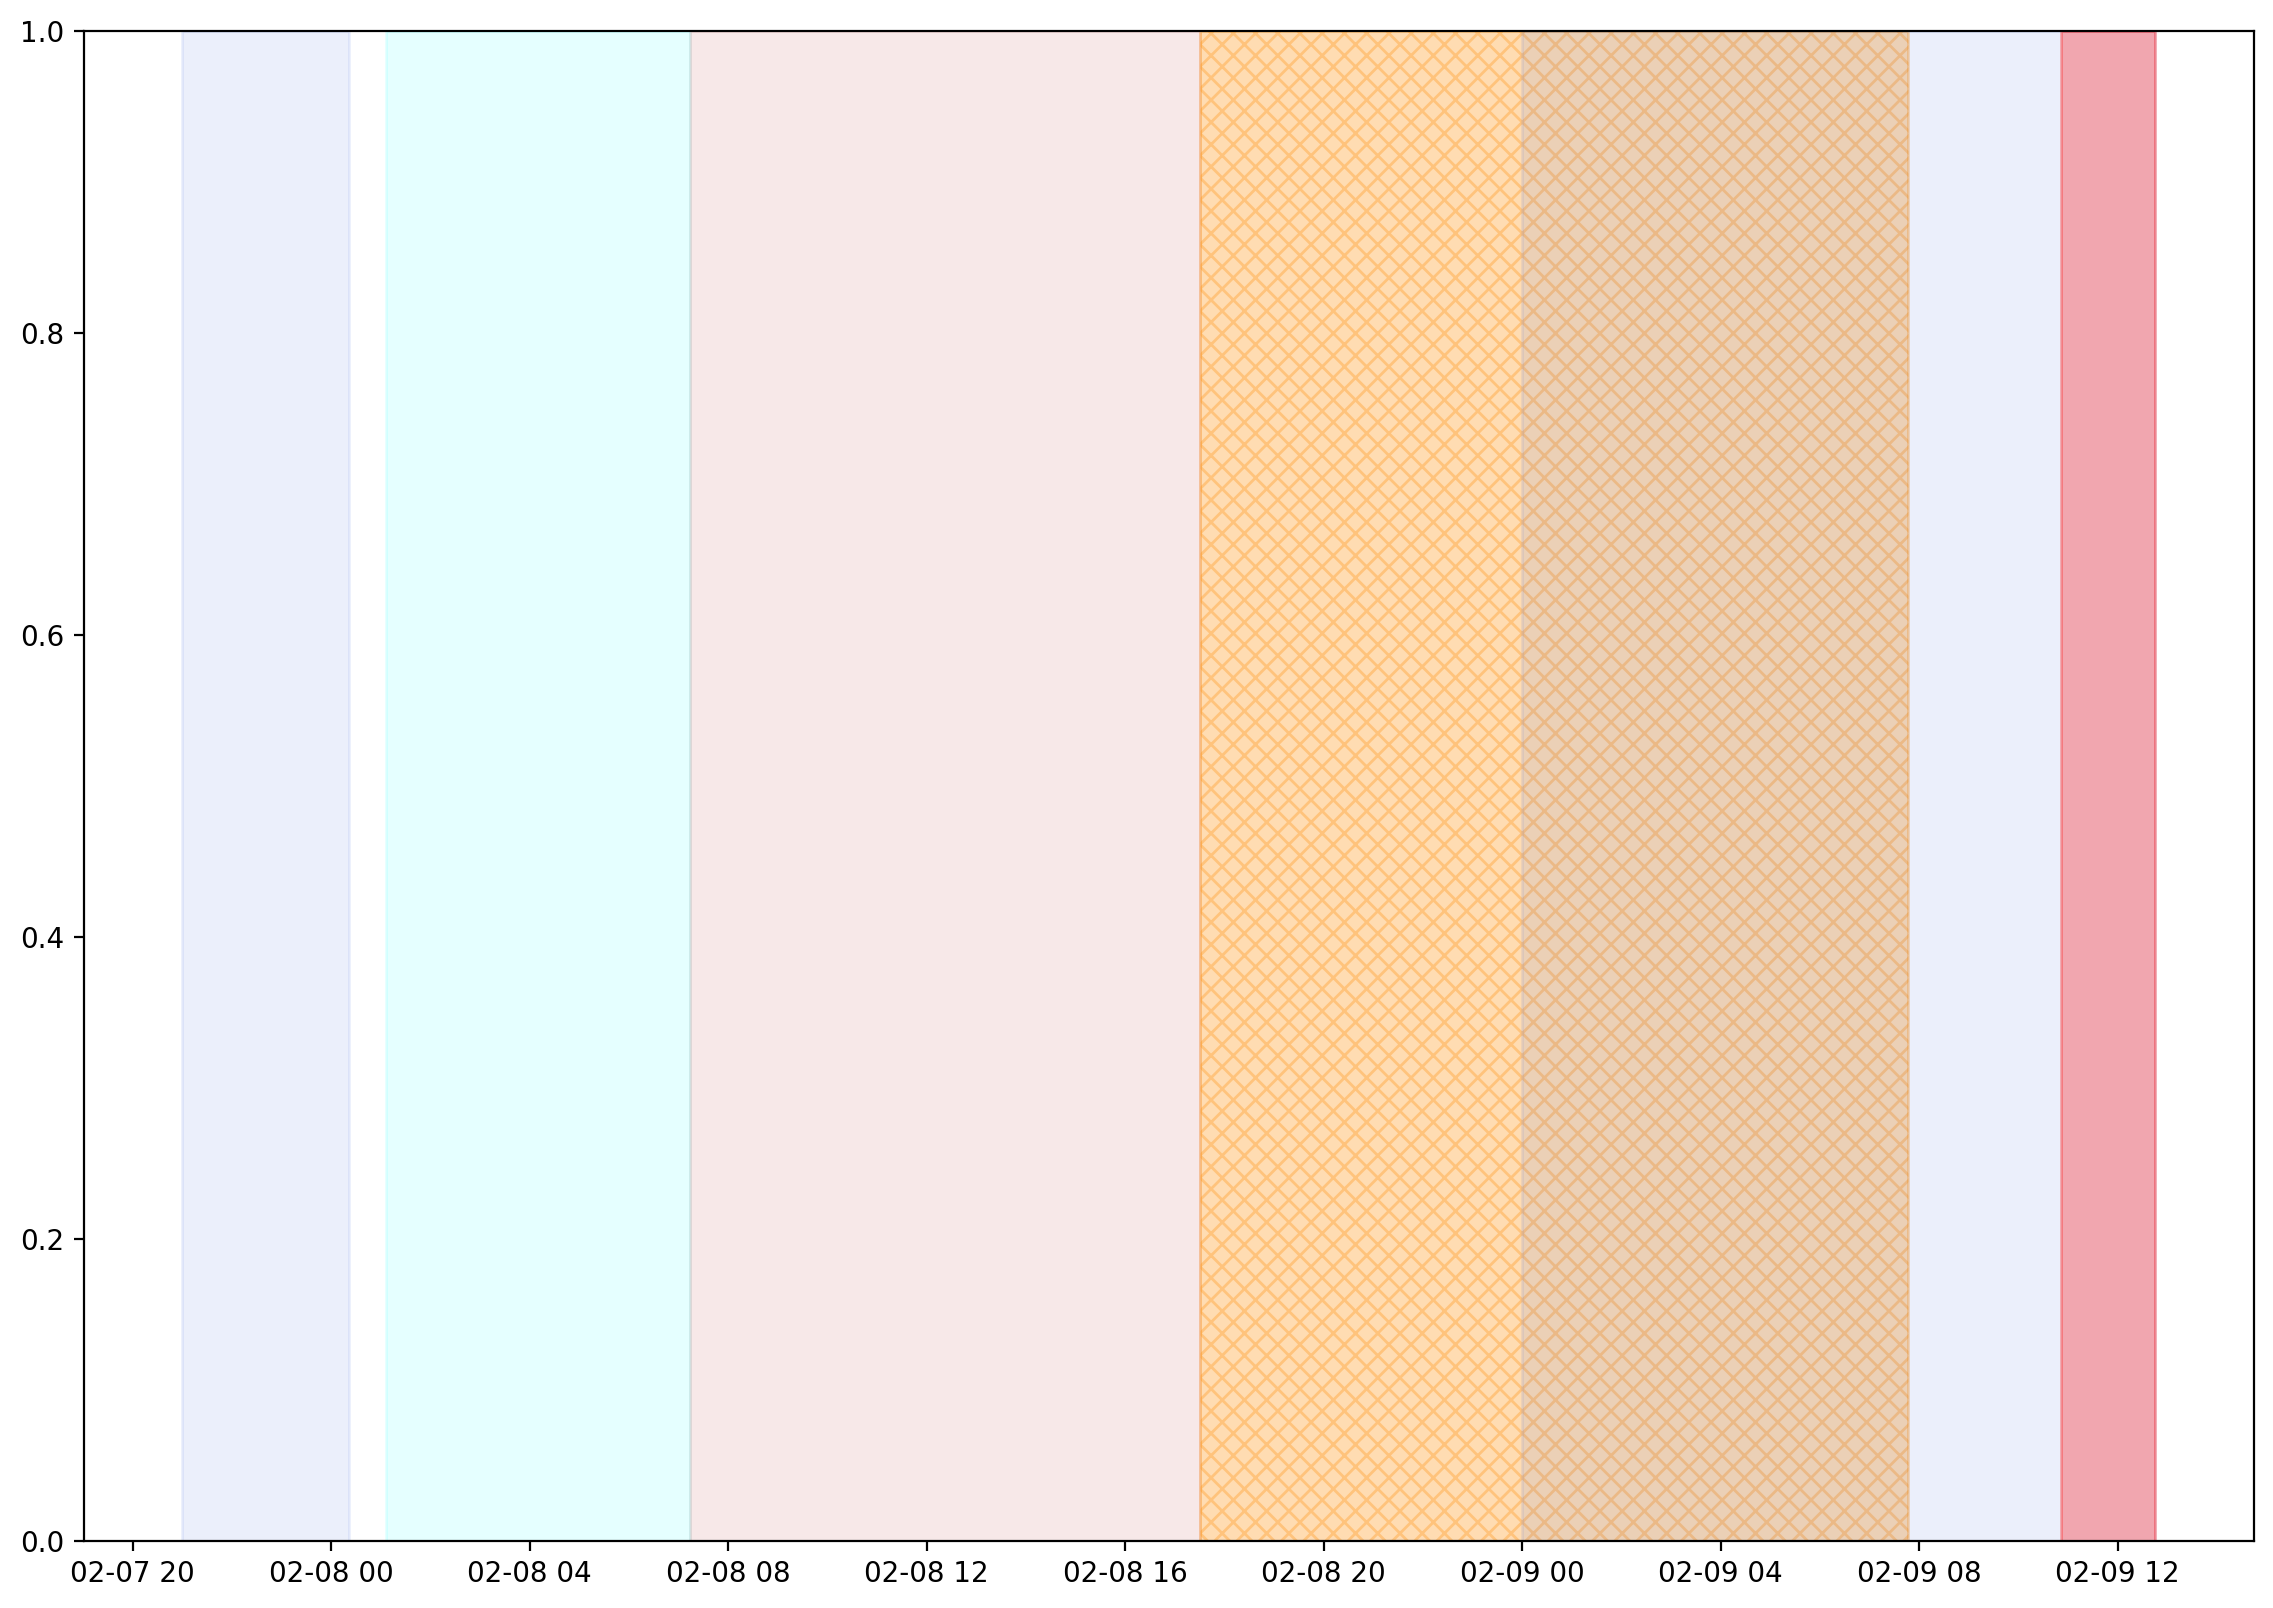

In [86]:
def GraphMasker():
    print(mainhsk_temp_sensors)
    print("Which of the following parts do you want to look at?")
    I = int(input())
    if I > 25 or I < 0:
        print("Bro, come on.")
    else:
        # Now make a plot
        fig = plt.figure(figsize=(14, 10), dpi=200)
        axs=fig.add_subplot(111)
        gs = fig.add_gridspec(1, 1)
        #axs = gs.subplots(sharex=True, sharey=False)
        #axs = gs.subplots()
        #axs.scatter(times, pressure, marker='.')
        #axs.set_ylabel("Pressure (Torr)")
        #axs.set_ylim([1, 759])
        # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
        # datetime(year, month, day, hour, minute, second, microsecond)
        #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
        cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
        cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
        power_on_DAQ = times[start_power]
        cold_case_start=datetime(2022, 2, 8,1,6,0,0)
        cold_case_end=datetime(2022, 2, 8,7,14,0,0)
        hot_case_start=cold_case_end
        hot_case_end=datetime(2022, 2, 8,17,30,0,0)
        kickflip_start=hot_case_end
        discharge_magnet = datetime(2022,2,8,20,35,0,0)
        discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
        drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
        #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
        cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
        cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
        kickflip_end=datetime(2022,2,9,7,46,0,0)
        slight_warmup_start=datetime(2022,2,9,10,52,0,0)
        drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
        slight_warmup_end=datetime(2022,2,9,12,45,0,0)
        evacuation_start = datetime(2022,2,7,17,45,0,0)
        evacuation_end = datetime(2022,2,9,17,00,0,0)
        DAQ_Run = datetime(2022,2,8,5,41,0,0)
        DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
        heater_start=datetime(2022,2,8,13,18,0,0)
        heater_max=datetime(2022,2,8,18,52,0,0)
        # hatches for timespans
        axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
        axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
        axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
        axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
        axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
        axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
        #size for markers visibility
        s0=40
        sM = 30
        axs.scatter(times, mainhsk_temps_array[:,I], marker='x',s=s0,label=mainhsk_names.Location.values[I])
        axs.scatter(times, Masking(I,1), marker='x',s=s0,label=mainhsk_names.Location.values[I])
        axs.set_ylabel("Temps (C)")
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
        plt.gcf().autofmt_xdate()
        #axs[0].grid()
        axs.grid()
        #plt.legend(loc='upper center', fontsize=8)
        handles, labels = axs.get_legend_handles_labels()
        #lgd = axs[1].legend(handles, labels)
        #for legend_handle in lgd.legendHandles:
        #    legend_handle.set_sizes([20])
        #labels[6]._legmarker.set_markersize(6)
        lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
        # as many of these as axs[1].scatter above
    
    return I
    
GraphMasker()

In [102]:
def GraphMasker():
    print(mainhsk_temp_sensors)
    print("Which of the following parts do you want to look at?")
    I = int(input())
    if I > 25 or I < 0:
        print("Bro, come on.")
    else:
        # Now make a plot
        fig = plt.figure(figsize=(14, 10), dpi=200)
        axs=fig.add_subplot(111)
        gs = fig.add_gridspec(1, 1)
        #axs = gs.subplots(sharex=True, sharey=False)
        #axs = gs.subplots()
        #axs.scatter(times, pressure, marker='.')
        #axs.set_ylabel("Pressure (Torr)")
        #axs.set_ylim([1, 759])
        # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
        # datetime(year, month, day, hour, minute, second, microsecond)
        #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
        cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
        cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
        power_on_DAQ = times[start_power]
        cold_case_start=datetime(2022, 2, 8,1,6,0,0)
        cold_case_end=datetime(2022, 2, 8,7,14,0,0)
        hot_case_start=cold_case_end
        hot_case_end=datetime(2022, 2, 8,17,30,0,0)
        kickflip_start=hot_case_end
        discharge_magnet = datetime(2022,2,8,20,35,0,0)
        discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
        drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
        #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
        cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
        cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
        kickflip_end=datetime(2022,2,9,7,46,0,0)
        slight_warmup_start=datetime(2022,2,9,10,52,0,0)
        drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
        slight_warmup_end=datetime(2022,2,9,12,45,0,0)
        evacuation_start = datetime(2022,2,7,17,45,0,0)
        evacuation_end = datetime(2022,2,9,17,00,0,0)
        DAQ_Run = datetime(2022,2,8,5,41,0,0)
        DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
        heater_start=datetime(2022,2,8,13,18,0,0)
        heater_max=datetime(2022,2,8,18,52,0,0)
        # hatches for timespans
        axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
        axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
        axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
        axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
        axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
        axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
        #size for markers visibility
        s0=40
        sM = 30
        axs.scatter(times, mainhsk_temps_array[:,I], marker='x',s=s0,label=mainhsk_names.Location.values[I])
        if I == 12 or I == 24:
            dT = 2
            axs.scatter(times, Masking(I,dT), marker='.',s=sM,label=mainhsk_names.Location.values[I])
        elif I == 11:
            dT = 1.5
            axs.scatter(times, Masking(I,dT), marker='.',s=sM,label=mainhsk_names.Location.values[I])
        elif I == 7:
            dT = 3
            axs.scatter(times, Masking(I,dT), marker='.',s=sM,label=mainhsk_names.Location.values[I])
        else:
            dT = 1
            axs.scatter(times, Masking(I,dT), marker='.',s=sM,label=mainhsk_names.Location.values[I])
        axs.set_ylabel("Temps (C)")
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
        plt.gcf().autofmt_xdate()
        #axs[0].grid()
        axs.grid()
        #plt.legend(loc='upper center', fontsize=8)
        handles, labels = axs.get_legend_handles_labels()
        #lgd = axs[1].legend(handles, labels)
        #for legend_handle in lgd.legendHandles:
        #    legend_handle.set_sizes([20])
        #labels[6]._legmarker.set_markersize(6)
        lgd=fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8)
        # as many of these as axs[1].scatter above
    
    return plt.show()

                          Location  Array index
0                   RICH FP btm SW            0
1                         DCTV top            1
2                       DCT HV box            2
3                    Gondola btm S            3
4                    Gondola btm W            4
5                        TOF btm S            5
6                    SFC backplate            6
7                        TOF top S            7
8                    Gondola mid S            8
9                     RICH cover S            9
10         DCTV bottom/Bore paddle           10
11       bore paddle readout board           11
12       TOF top E-FEE thermal bar           12
13  Gondola mid E on RICH heatsink           13
14  Gondola mid W on RICH heatsink           14
15                       Gas panel           15
16                       TOF btm N           16
17                    RICH cover E           17
18                    RICH cover N           18
19                    RICH cover W      

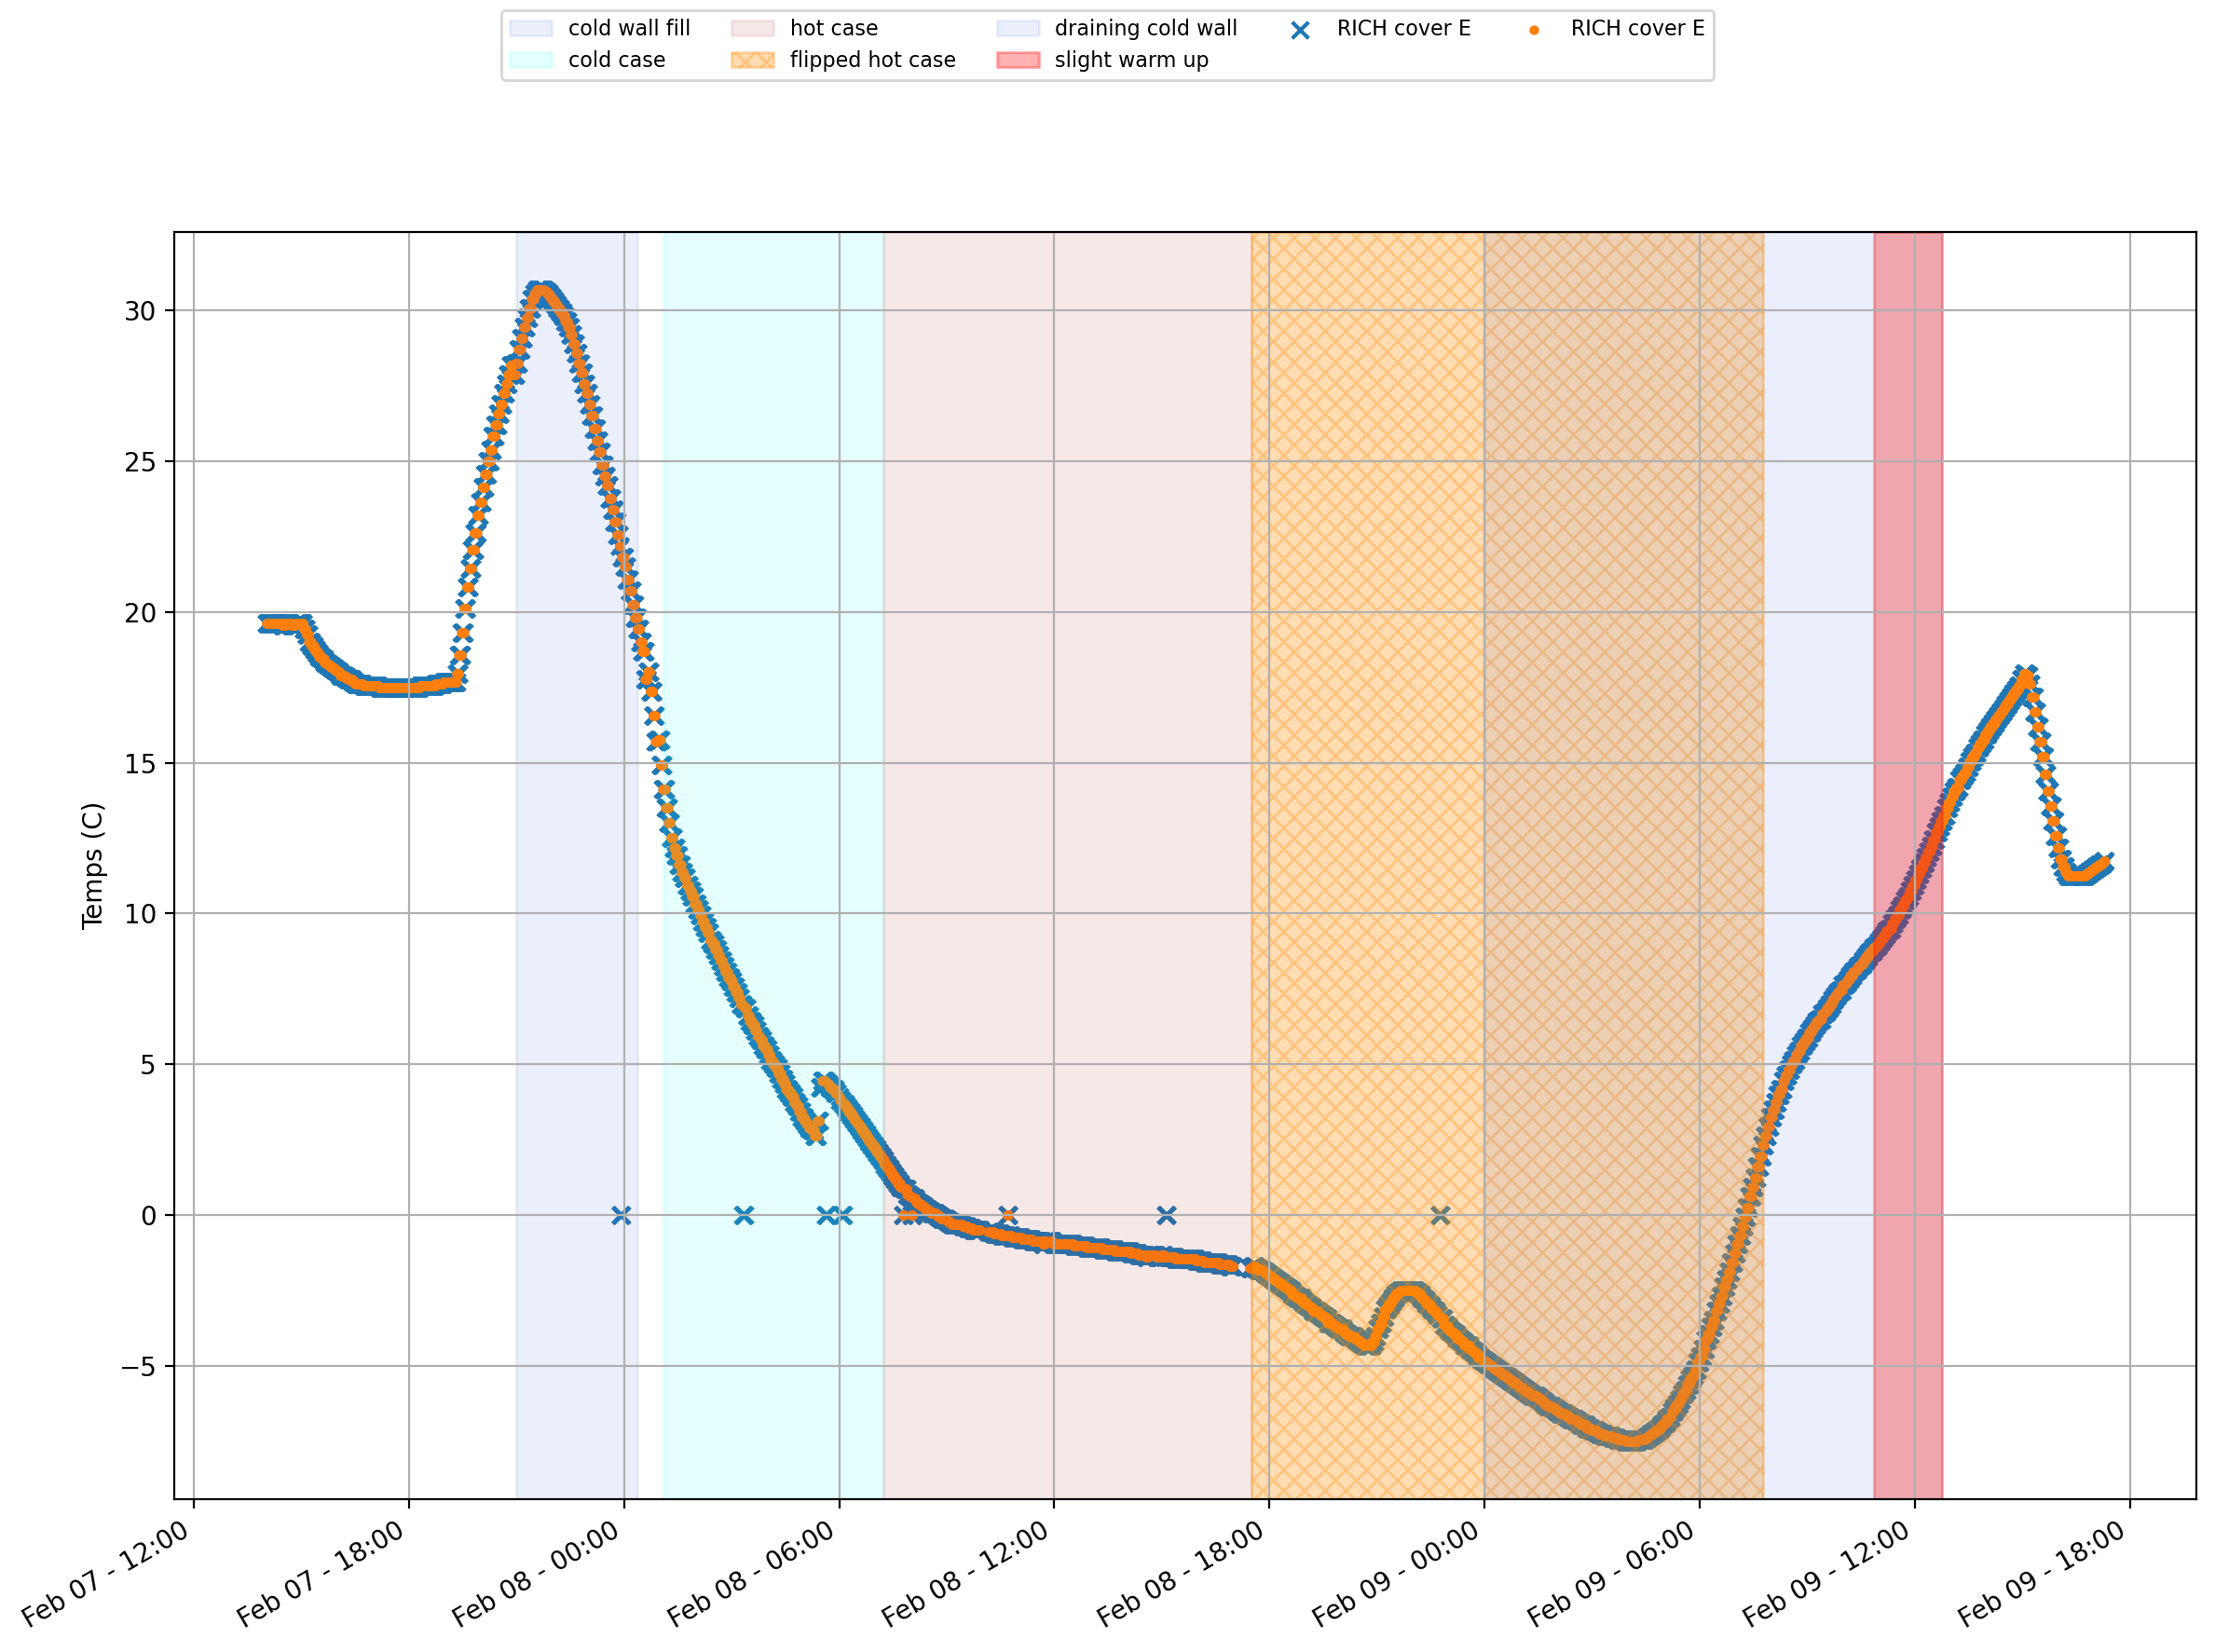

In [103]:
GraphMasker()